# Classical Exact Cellular Decomposition Methods

In [1]:
import os
from IPython.display import clear_output
import time
from PIL import Image, ImageDraw
from typing import Optional, List, Dict, Tuple, Union, Set, Any
import pandas as pd
from uuid import uuid4
import numpy as np
from matplotlib import pyplot as plt
from random import randint, shuffle, seed
import sys
import seaborn as sns

## Main Part

In [2]:
class Map:
    """
    Map format https://movingai.com/benchmarks/formats.html
    """
    def __init__(self, map_path: str, map_tasks_path: Optional[str] = None, *args, **kwargs):
        """
        :param map_path: path to map file
        :param map_tasks_path: path to task file for this map, can be installed later
        """
        assert os.path.exists(map_path), f"path \"{map_path}\" not exists"
        assert map_tasks_path is None or os.path.exists(map_tasks_path), f"path \"{map_tasks_path}\" not exists"

        self.map = self.read_map_from_file(map_path, *args, **kwargs)
        self.map_tasks_path = map_tasks_path

    @staticmethod
    def read_map_from_file(path: str, with_scale_2: bool = False) -> List[List[int]]:
        """
        :param path: path to map file
        :param with_scale_2: scale map or not
        :return: cells: List[List[int]], 0 if cell is empty else 1
        """
        scale = 2 if with_scale_2 else 1
        with open(path, 'r') as f:
            assert f.readline() == "type octile\n"
            height_name, h = f.readline().split()
            assert height_name == "height"
            width_name, w = f.readline().split()
            assert width_name == "width"
            assert f.readline() == "map\n"

            height, width = int(h), int(w)
            cells = [[0 for _ in range(width * scale)] for _ in range(height * scale)]

            for i, l in enumerate(f.read().splitlines()):
                assert len(l) >= width, f"wrong width {len(l)} < {width}"
                for j, c in enumerate(l):
                    if c != '.' and c != 'G':
                        if scale == 1:
                            cells[i][j] = 1
                        else:
                            cells[i * scale][j * scale] = 1
                            cells[i * scale + 1][j * scale] = 1
                            cells[i * scale][j * scale + 1] = 1
                            cells[i * scale + 1][j * scale + 1] = 1
                    if j == width * scale - 1:
                        break
                if i == height - 1:
                    break
        return cells

    @staticmethod
    def read_tasks_from_file(path: str, shuffle: bool = True, count: int = 100, random_state: Optional[int] = 42) -> pd.DataFrame:
        """
        work only with not scaled map
        :param path: path to task file for this map
        :param shuffle: random tasks from file or in order
        :param count: limit on the number of rows in a dataframe
        :param random_state: just random_state (use for df.sample). Use only if shuffle==True
        :return: pd.DataFrame of tasks settings
        """
        df = pd.read_csv(path, skiprows=1, header=None, sep='\s+', names=["level", "map", "height", "width", "start_j", "start_i", "goal_j", "goal_i", "length"])
        if shuffle:
            df = df.sample(frac=1, random_state=random_state)
        df = df.reset_index(drop=False)
        df["row"] = df["index"] + 2
        return df[:count]

    def set_tasks_path(self, path: str):
        """
        update map_tasks_path (use in read_tasks as a path of Map.read_tasks_from_file)
        """
        self.map_tasks_path = path

    def read_tasks(self, *args, **kwargs) -> pd.DataFrame:
        """
        executes Map.read_tasks_from_file with the previously specified path and forwards the arguments
        """
        assert os.path.exists(self.map_tasks_path), f"path \"{self.map_tasks_path}\" not exists"
        return self.read_tasks_from_file(self.map_tasks_path, *args, **kwargs)


In [3]:
mapa = Map("bench_data/AcrosstheCape.map", "bench_data/AcrosstheCape.map.scen")
tasks = mapa.read_tasks()
tasks.head()

,index,level,map,height,width,start_j,start_i,goal_j,goal_i,length,row
0,2965,296,AcrosstheCape.map,768,768,88,373,636,340,1185.028571,2967
1,969,96,AcrosstheCape.map,768,768,597,471,404,676,385.781746,971
2,1385,138,AcrosstheCape.map,768,768,179,271,585,297,552.416306,1387
3,1233,123,AcrosstheCape.map,768,768,332,203,120,133,494.457936,1235
4,2996,299,AcrosstheCape.map,768,768,29,47,693,303,1197.082394,2998


### Helpers

In [4]:
DEBUG_SLEEP = 0.1

In [5]:
def show_path(decompositor: Optional):
    if decompositor is None:
        return
    clear_output()
    decompositor.show()
    time.sleep(DEBUG_SLEEP)

def decompositor_add(decompositor, point: Tuple[int, int]) -> bool:
    if decompositor is None:
        return False
    decompositor.path.append((point[0] + decompositor.bias[0], point[1] + decompositor.bias[1]))
    show_path(decompositor)
    return True

def decompositor_pop(decompositor) -> Optional[Tuple[int, int]]:
    if decompositor is None or not decompositor.path:
        return None
    return decompositor.path.pop()

def decompositor_set_bias(decompositor, xy_bias: Tuple[int, int]):
    if decompositor is None:
        return
    decompositor.bias = xy_bias


In [6]:
def diff_between(xs: Tuple[int, int]) -> int:
    return abs(xs[0] - xs[1])


In [7]:
turns = [(0, 1), (-1, 0), (0, -1), (1, 0)]

def bfs_area(cells: List[List[int]], pos: Tuple[int, int]):
    def is_empty(x: int, y: int):
        return 0 <= x < len(cells) and 0 <= y < len(cells[0]) and cells[x][y] == 0

    covered = set()
    nexts = [pos]
    while nexts:
        pos = nexts.pop(0)
        if pos not in covered and is_empty(pos[0], pos[1]):
            covered.add(pos)
            for turn in turns:
                nexts.append((pos[0] + turn[0], pos[1] + turn[1]))
    return covered

def map_cells(mapa: Union[Map, List[List[int]]], start: Tuple[int, int]) -> Set[Tuple[int, int]]:
    cells = mapa if isinstance(mapa, list) else mapa.map
    covered = bfs_area(cells, start)

    return covered

def map_coverage(mapa: Union[Map, List[List[int]]], start: Tuple[int, int]) -> int:
    covered = map_cells(mapa, start)
    return len(covered)


In [8]:
maps = [
    [
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    ],
    [
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    ],
    [
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    ],
    [
        [0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    ],
    [
        [0, 0, 0, 0, 0, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    ],
]

In [9]:
print(map_coverage(maps[0], (0, 0)))
print(map_coverage(maps[1], (0, 0)))
print(map_coverage(mapa, (0, 0)))

70
60
391096


### Area coverage

In [10]:
class Area:
    def __init__(self, cells: List[List[int]], corners: List[Tuple[int, int]]):
        self.cells = cells
        self.corners = corners

    def is_empty(self, x: int, y: int) -> bool:
        return 0 <= x < len(self.cells) and 0 <= y < len(self.cells[0]) and self.cells[x][y] == 0

    def path_to_border(self, start: Tuple[int, int], direction_x: int, decompositor: Optional = None) -> List[Tuple[int, int]]: # path
        path = [start]
        decompositor_add(decompositor, start)
        x, y = start
        last_x = 0 if direction_x < 0 else len(self.cells) - 1

        while x != last_x:
            while x != last_x and self.is_empty(x + direction_x, y):
                x += direction_x
                path.append((x, y))
                decompositor_add(decompositor, (x, y))
            if x == last_x:
                continue

            direction_y = -1
            i = y
            while i < len(self.cells[0]):
                if self.cells[x][i] != 0:
                    break
                if self.cells[x + direction_x][i] == 0:
                    direction_y = 1
                    break
                i += 1

            while not self.is_empty(x + direction_x, y):
                y += direction_y
                assert self.is_empty(x, y), "area path_to_border failed"
                path.append((x, y))
                decompositor_add(decompositor, (x, y))
        return path

    def cover(self, start: Tuple[int, int], decompositor: Optional = None) -> List[Tuple[int, int]]:    # path
        pass


In [11]:
class ZigZagArea(Area):
    def __init__(self, cells: List[List[int]], corners: List[Tuple[int, int]]):
        super().__init__(cells, corners)

    def __start_corner(self, start: Tuple[int, int]) -> Tuple[int, int]:
        start_corner = None
        for corner in self.corners:
            if corner[0] != start[0]:
                continue
            if start_corner is None or abs(corner[1] - start[1]) < abs(start_corner[1] - start[1]):
                start_corner = corner
        assert start_corner is not None, f"wrong start position: {start}"
        return start_corner

    def __start_direction(self, pos: Tuple[int, int]) -> Tuple[int, int]:
        direction_x = 1 if pos[0] == 0 else -1
        direction_y = 1 if pos[1] + 1 < len(self.cells[0]) and self.cells[pos[0]][pos[1] + 1] == 0 else -1
        return direction_x, direction_y

    def pre_cover(self, start: Tuple[int, int], decompositor: Optional = None) -> List[Tuple[int, int]]:
        path = []
        start_corner = self.__start_corner(start)
        assert start[0] == start_corner[0], "wrong start corner"
        direction = 1 if start_corner[1] > start[1] else -1
        while start_corner[1] != start[1]:
            assert self.is_empty(start[0], start[1]), "cell is not empty"
            path.append(start)
            decompositor_add(decompositor, start)
            start = (start[0], start[1] + direction)
        assert self.is_empty(start[0], start[1]), "cell is not empty"
        path.append(start)
        decompositor_add(decompositor, start)
        return path

    def cover(self, start: Tuple[int, int], decompositor: Optional = None) -> List[Tuple[int, int]]:
        path = self.pre_cover(start, decompositor)
        pos = path[-1]
        x, y = pos
        direction_x, direction_y = self.__start_direction(pos)
        last_x = 0 if direction_x < 0 else len(self.cells) - 1

        while True:
            while self.is_empty(x, y + direction_y):
                y += direction_y
                path.append((x, y))
                decompositor_add(decompositor, (x, y))
            if x == last_x:
                break
            while not self.is_empty(x + direction_x, y):
                y -= direction_y
                assert self.is_empty(x, y), "area cover failed"
                path.append((x, y))
                decompositor_add(decompositor, (x, y))
            x += direction_x
            path.append((x, y))
            decompositor_add(decompositor, (x, y))
            while self.is_empty(x, y + direction_y):
                y += direction_y
                path.append((x, y))
                decompositor_add(decompositor, (x, y))
            direction_y = -direction_y
        return path


In [12]:
class SpiralSTCArea(Area):
    def __init__(self, cells: List[List[int]], corners: List[Tuple[int, int]], doubled: bool=True):
        super().__init__(cells, corners)
        self.double_cells = []
        if doubled:
            for i in range(0, len(cells), 2):
                self.double_cells.append([])
                for j in range(0, len(cells[0]), 2):
                    self.double_cells[i // 2].append(cells[i][j])
        else:
            self.double_cells = cells
        self.old = set()

    def __start_direction(self, current: Tuple[int, int], parent: Tuple[int, int]) -> Tuple[int, int]:
        if parent is None:
            return 0, -1
        else:
            return parent[0] - current[0], parent[1] - current[1]
        
    def __next_direction(self, direction: Tuple[int, int]) -> Tuple[int, int]:
        return -direction[1], direction[0]

    def __is_empty(self, x: int, y: int) -> bool:
        return 0 <= x < len(self.double_cells) and 0 <= y < len(self.double_cells[0]) and self.double_cells[x][y] == 0
    
    def __spiral_stc(
        self, 
        start: Tuple[int, int]
    ) -> List[Tuple[int, int]]:
        path = []
        vertices = []
        vertices.append((start, None))
        while len(vertices) != 0:
            current, parent = vertices.pop()
            self.old.add(current)
            path.append(current)
            direction = self.__start_direction(current, parent)
            for _ in range(4):
                next_cell = current[0] + direction[0], current[1] + direction[1]
                if self.__is_empty(next_cell[0], next_cell[1]) and next_cell not in self.old:
                    vertices.append((current, parent))
                    vertices.append((next_cell, current))
                    break
                direction = self.__next_direction(direction)

        return path
    
    def __compute_cleaner_moves(self, path: List[Tuple[int, int]]) -> List[Tuple[int, int]]:
        cleaner_path = []
        if len(path) < 2:
            return []
        direction = path[1][0] - path[0][0], path[1][1] - path[0][1]
        if direction[0] == -1 and direction[1] == 0:
            cleaner_path.append((2 * path[0][0] + 1, 2 * path[0][1] + 1))
            cleaner_path.append((2 * path[0][0], 2 * path[0][1] + 1))
        if direction[0] == 1 and direction[1] == 0:
            cleaner_path.append((2 * path[0][0], 2 * path[0][1]))
            cleaner_path.append((2 * path[0][0] + 1, 2 * path[0][1]))
        if direction[0] == 0 and direction[1] == -1:
            cleaner_path.append((2 * path[0][0], 2 * path[0][1] + 1))
            cleaner_path.append((2 * path[0][0], 2 * path[0][1]))
        if direction[0] == 0 and direction[1] == 1:
            cleaner_path.append((2 * path[0][0] + 1, 2 * path[0][1]))
            cleaner_path.append((2 * path[0][0] + 1, 2 * path[0][1] + 1))
        
        for i in range(1, len(path) - 1):
            move_1 = path[i][0] - path[i - 1][0], path[i][1] - path[i - 1][1]
            move_2 = path[i + 1][0] - path[i][0], path[i + 1][1] - path[i][1]

            if move_1[0] == 1 and move_1[1] == 0 and move_2[0] == 1 and move_2[1] == 0:
                cleaner_path.append((2 * path[i][0], 2 * path[i][1]))
                cleaner_path.append((2 * path[i][0] + 1, 2 * path[i][1]))
            if move_1[0] == -1 and move_1[1] == 0 and move_2[0] == -1 and move_2[1] == 0:
                cleaner_path.append((2 * path[i][0] + 1, 2 * path[i][1] + 1))
                cleaner_path.append((2 * path[i][0], 2 * path[i][1] + 1))
            if move_1[0] == 0 and move_1[1] == 1 and move_2[0] == 0 and move_2[1] == 1:
                cleaner_path.append((2 * path[i][0] + 1, 2 * path[i][1]))
                cleaner_path.append((2 * path[i][0] + 1, 2 * path[i][1] + 1))
            if move_1[0] == 0 and move_1[1] == -1 and move_2[0] == 0 and move_2[1] == -1:
                cleaner_path.append((2 * path[i][0], 2 * path[i][1] + 1))
                cleaner_path.append((2 * path[i][0], 2 * path[i][1]))
            if move_1[0] == 1 and move_1[1] == 0 and move_2[0] == -1 and move_2[1] == 0:
                cleaner_path.append((2 * path[i][0], 2 * path[i][1]))
                cleaner_path.append((2 * path[i][0] + 1, 2 * path[i][1]))
                cleaner_path.append((2 * path[i][0] + 1, 2 * path[i][1] + 1))
                cleaner_path.append((2 * path[i][0], 2 * path[i][1] + 1))
            if move_1[0] == -1 and move_1[1] == 0 and move_2[0] == 1 and move_2[1] == 0:
                cleaner_path.append((2 * path[i][0] + 1, 2 * path[i][1] + 1))
                cleaner_path.append((2 * path[i][0], 2 * path[i][1] + 1))
                cleaner_path.append((2 * path[i][0], 2 * path[i][1]))
                cleaner_path.append((2 * path[i][0] + 1, 2 * path[i][1]))
            if move_1[0] == 0 and move_1[1] == 1 and move_2[0] == 0 and move_2[1] == -1:
                cleaner_path.append((2 * path[i][0] + 1, 2 * path[i][1]))
                cleaner_path.append((2 * path[i][0] + 1, 2 * path[i][1] + 1))
                cleaner_path.append((2 * path[i][0], 2 * path[i][1] + 1))
                cleaner_path.append((2 * path[i][0], 2 * path[i][1]))
            if move_1[0] == 0 and move_1[1] == -1 and move_2[0] == 0 and move_2[1] == 1:
                cleaner_path.append((2 * path[i][0], 2 * path[i][1] + 1))
                cleaner_path.append((2 * path[i][0], 2 * path[i][1]))
                cleaner_path.append((2 * path[i][0] + 1, 2 * path[i][1]))
                cleaner_path.append((2 * path[i][0] + 1, 2 * path[i][1] + 1))
            if move_1[0] == 1 and move_1[1] == 0 and move_2[0] == 0 and move_2[1] == 1:
                cleaner_path.append((2 * path[i][0], 2 * path[i][1]))
                cleaner_path.append((2 * path[i][0] + 1, 2 * path[i][1]))
                cleaner_path.append((2 * path[i][0] + 1, 2 * path[i][1] + 1))
            if move_1[0] == 0 and move_1[1] == 1 and move_2[0] == -1 and move_2[1] == 0:
                cleaner_path.append((2 * path[i][0] + 1, 2 * path[i][1]))
                cleaner_path.append((2 * path[i][0] + 1, 2 * path[i][1] + 1))
                cleaner_path.append((2 * path[i][0], 2 * path[i][1] + 1))
            if move_1[0] == -1 and move_1[1] == 0 and move_2[0] == 0 and move_2[1] == -1:
                cleaner_path.append((2 * path[i][0] + 1, 2 * path[i][1] + 1))
                cleaner_path.append((2 * path[i][0], 2 * path[i][1] + 1))
                cleaner_path.append((2 * path[i][0], 2 * path[i][1]))
            if move_1[0] == 0 and move_1[1] == -1 and move_2[0] == 1 and move_2[1] == 0:
                cleaner_path.append((2 * path[i][0], 2 * path[i][1] + 1))
                cleaner_path.append((2 * path[i][0], 2 * path[i][1]))
                cleaner_path.append((2 * path[i][0] + 1, 2 * path[i][1]))
            if move_1[0] == 1 and move_1[1] == 0 and move_2[0] == 0 and move_2[1] == -1:
                cleaner_path.append((2 * path[i][0], 2 * path[i][1]))
            if move_1[0] == 0 and move_1[1] == -1 and move_2[0] == -1 and move_2[1] == 0:
                cleaner_path.append((2 * path[i][0], 2 * path[i][1] + 1))
            if move_1[0] == -1 and move_1[1] == 0 and move_2[0] == 0 and move_2[1] == 1:
                cleaner_path.append((2 * path[i][0] + 1, 2 * path[i][1] + 1))
            if move_1[0] == 0 and move_1[1] == 1 and move_2[0] == 1 and move_2[1] == 0:
                cleaner_path.append((2 * path[i][0] + 1, 2 * path[i][1]))

        i = len(path) - 1
        direction = path[i][0] - path[i - 1][0], path[i][1] - path[i - 1][1]
        if direction[0] == -1 and direction[1] == 0:
            cleaner_path.append((2 * path[i][0] + 1, 2 * path[i][1] + 1))
            cleaner_path.append((2 * path[i][0], 2 * path[i][1] + 1))
        if direction[0] == 1 and direction[1] == 0:
            cleaner_path.append((2 * path[i][0], 2 * path[i][1]))
            cleaner_path.append((2 * path[i][0] + 1, 2 * path[i][1]))
        if direction[0] == 0 and direction[1] == -1:
            cleaner_path.append((2 * path[i][0], 2 * path[i][1] + 1))
            cleaner_path.append((2 * path[i][0], 2 * path[i][1]))
        if direction[0] == 0 and direction[1] == 1:
            cleaner_path.append((2 * path[i][0] + 1, 2 * path[i][1]))
            cleaner_path.append((2 * path[i][0] + 1, 2 * path[i][1] + 1))
        
        return cleaner_path

    
    def cover(self, start: Tuple[int, int], decompositor: Optional=None) -> List[Tuple[int, int]]:
        spanning_tree = self.__spiral_stc(start)
        return self.__compute_cleaner_moves(spanning_tree)


In [13]:
class ScanSTCArea(Area):
    def __init__(self, cells: List[List[int]], corners: List[Tuple[int, int]], doubled: bool=True):
        super().__init__(cells, corners)
        self.double_cells = []
        if doubled:
            for i in range(0, len(cells), 2):
                self.double_cells.append([])
                for j in range(0, len(cells[0]), 2):
                    self.double_cells[i // 2].append(cells[i][j])
        else:
            self.double_cells = cells
        self.old = set()
        
    def __start_direction(self, current: Tuple[int, int], parent: Tuple[int, int]) -> Tuple[int, int]:
        if parent is None:
            return 1, 0
        else:
            return parent[0] - current[0], parent[1] - current[1]

    def __next_direction(self, direction: Tuple[int, int]) -> Tuple[int, int]:
        return -direction[1], direction[0]    
        
    def __check_direction(self, direction: Tuple[int, int], preferred_direction: Tuple[int, int]) -> bool:
        return abs(direction[0]) == abs(preferred_direction[0]) and abs(direction[1]) == abs(preferred_direction[1])
        
    def __is_empty(self, x: int, y: int) -> bool:
        return 0 <= x < len(self.double_cells) and 0 <= y < len(self.double_cells[0]) and self.double_cells[x][y] == 0
    
    def __scan_stc(
        self, 
        start: Tuple[int, int],
        preferred_direction: Tuple[int, int]=(1,0)
    ) -> List[Tuple[int, int]]:
        path = []
        vertices = []
        vertices.append((start, None))
        while len(vertices) != 0:
            current, parent = vertices.pop()
            self.old.add(current)
            path.append(current)
            direction = self.__start_direction(current, parent)
            for _ in range(4):
                next_cell = current[0] + direction[0], current[1] + direction[1]
                if not self.__is_empty(next_cell[0], next_cell[1]) or next_cell in self.old:
                    direction = self.__next_direction(direction)
                    continue
                if not self.__check_direction(direction, preferred_direction):
                    next_direction = self.__next_direction(direction)
                    mid_direction = direction[0] + next_direction[0], direction[1] + next_direction[1]
                    next_direction_cell = current[0] + next_direction[0], current[1] + next_direction[1]
                    mid_direction_cell = current[0] + mid_direction[0], current[1] + mid_direction[1]
                    if self.__is_empty(next_direction_cell[0], next_direction_cell[1]) and self.__is_empty(mid_direction_cell[0], mid_direction_cell[1]):
                        direction = self.__next_direction(direction)
                        continue
                vertices.append((current, parent))
                vertices.append((next_cell, current))
                break

        return path
    
    def __compute_cleaner_moves(self, path: List[Tuple[int, int]]) -> List[Tuple[int, int]]:
        cleaner_path = []
        if len(path) < 2:
            return []
        direction = path[1][0] - path[0][0], path[1][1] - path[0][1]
        if direction[0] == -1 and direction[1] == 0:
            cleaner_path.append((2 * path[0][0] + 1, 2 * path[0][1] + 1))
            cleaner_path.append((2 * path[0][0], 2 * path[0][1] + 1))
        if direction[0] == 1 and direction[1] == 0:
            cleaner_path.append((2 * path[0][0], 2 * path[0][1]))
            cleaner_path.append((2 * path[0][0] + 1, 2 * path[0][1]))
        if direction[0] == 0 and direction[1] == -1:
            cleaner_path.append((2 * path[0][0], 2 * path[0][1] + 1))
            cleaner_path.append((2 * path[0][0], 2 * path[0][1]))
        if direction[0] == 0 and direction[1] == 1:
            cleaner_path.append((2 * path[0][0] + 1, 2 * path[0][1]))
            cleaner_path.append((2 * path[0][0] + 1, 2 * path[0][1] + 1))
        
        for i in range(1, len(path) - 1):
            move_1 = path[i][0] - path[i - 1][0], path[i][1] - path[i - 1][1]
            move_2 = path[i + 1][0] - path[i][0], path[i + 1][1] - path[i][1]

            if move_1[0] == 1 and move_1[1] == 0 and move_2[0] == 1 and move_2[1] == 0:
                cleaner_path.append((2 * path[i][0], 2 * path[i][1]))
                cleaner_path.append((2 * path[i][0] + 1, 2 * path[i][1]))
            if move_1[0] == -1 and move_1[1] == 0 and move_2[0] == -1 and move_2[1] == 0:
                cleaner_path.append((2 * path[i][0] + 1, 2 * path[i][1] + 1))
                cleaner_path.append((2 * path[i][0], 2 * path[i][1] + 1))
            if move_1[0] == 0 and move_1[1] == 1 and move_2[0] == 0 and move_2[1] == 1:
                cleaner_path.append((2 * path[i][0] + 1, 2 * path[i][1]))
                cleaner_path.append((2 * path[i][0] + 1, 2 * path[i][1] + 1))
            if move_1[0] == 0 and move_1[1] == -1 and move_2[0] == 0 and move_2[1] == -1:
                cleaner_path.append((2 * path[i][0], 2 * path[i][1] + 1))
                cleaner_path.append((2 * path[i][0], 2 * path[i][1]))
            if move_1[0] == 1 and move_1[1] == 0 and move_2[0] == -1 and move_2[1] == 0:
                cleaner_path.append((2 * path[i][0], 2 * path[i][1]))
                cleaner_path.append((2 * path[i][0] + 1, 2 * path[i][1]))
                cleaner_path.append((2 * path[i][0] + 1, 2 * path[i][1] + 1))
                cleaner_path.append((2 * path[i][0], 2 * path[i][1] + 1))
            if move_1[0] == -1 and move_1[1] == 0 and move_2[0] == 1 and move_2[1] == 0:
                cleaner_path.append((2 * path[i][0] + 1, 2 * path[i][1] + 1))
                cleaner_path.append((2 * path[i][0], 2 * path[i][1] + 1))
                cleaner_path.append((2 * path[i][0], 2 * path[i][1]))
                cleaner_path.append((2 * path[i][0] + 1, 2 * path[i][1]))
            if move_1[0] == 0 and move_1[1] == 1 and move_2[0] == 0 and move_2[1] == -1:
                cleaner_path.append((2 * path[i][0] + 1, 2 * path[i][1]))
                cleaner_path.append((2 * path[i][0] + 1, 2 * path[i][1] + 1))
                cleaner_path.append((2 * path[i][0], 2 * path[i][1] + 1))
                cleaner_path.append((2 * path[i][0], 2 * path[i][1]))
            if move_1[0] == 0 and move_1[1] == -1 and move_2[0] == 0 and move_2[1] == 1:
                cleaner_path.append((2 * path[i][0], 2 * path[i][1] + 1))
                cleaner_path.append((2 * path[i][0], 2 * path[i][1]))
                cleaner_path.append((2 * path[i][0] + 1, 2 * path[i][1]))
                cleaner_path.append((2 * path[i][0] + 1, 2 * path[i][1] + 1))
            if move_1[0] == 1 and move_1[1] == 0 and move_2[0] == 0 and move_2[1] == 1:
                cleaner_path.append((2 * path[i][0], 2 * path[i][1]))
                cleaner_path.append((2 * path[i][0] + 1, 2 * path[i][1]))
                cleaner_path.append((2 * path[i][0] + 1, 2 * path[i][1] + 1))
            if move_1[0] == 0 and move_1[1] == 1 and move_2[0] == -1 and move_2[1] == 0:
                cleaner_path.append((2 * path[i][0] + 1, 2 * path[i][1]))
                cleaner_path.append((2 * path[i][0] + 1, 2 * path[i][1] + 1))
                cleaner_path.append((2 * path[i][0], 2 * path[i][1] + 1))
            if move_1[0] == -1 and move_1[1] == 0 and move_2[0] == 0 and move_2[1] == -1:
                cleaner_path.append((2 * path[i][0] + 1, 2 * path[i][1] + 1))
                cleaner_path.append((2 * path[i][0], 2 * path[i][1] + 1))
                cleaner_path.append((2 * path[i][0], 2 * path[i][1]))
            if move_1[0] == 0 and move_1[1] == -1 and move_2[0] == 1 and move_2[1] == 0:
                cleaner_path.append((2 * path[i][0], 2 * path[i][1] + 1))
                cleaner_path.append((2 * path[i][0], 2 * path[i][1]))
                cleaner_path.append((2 * path[i][0] + 1, 2 * path[i][1]))
            if move_1[0] == 1 and move_1[1] == 0 and move_2[0] == 0 and move_2[1] == -1:
                cleaner_path.append((2 * path[i][0], 2 * path[i][1]))
            if move_1[0] == 0 and move_1[1] == -1 and move_2[0] == -1 and move_2[1] == 0:
                cleaner_path.append((2 * path[i][0], 2 * path[i][1] + 1))
            if move_1[0] == -1 and move_1[1] == 0 and move_2[0] == 0 and move_2[1] == 1:
                cleaner_path.append((2 * path[i][0] + 1, 2 * path[i][1] + 1))
            if move_1[0] == 0 and move_1[1] == 1 and move_2[0] == 1 and move_2[1] == 0:
                cleaner_path.append((2 * path[i][0] + 1, 2 * path[i][1]))

        i = len(path) - 1
        direction = path[i][0] - path[i - 1][0], path[i][1] - path[i - 1][1]
        if direction[0] == -1 and direction[1] == 0:
            cleaner_path.append((2 * path[i][0] + 1, 2 * path[i][1] + 1))
            cleaner_path.append((2 * path[i][0], 2 * path[i][1] + 1))
        if direction[0] == 1 and direction[1] == 0:
            cleaner_path.append((2 * path[i][0], 2 * path[i][1]))
            cleaner_path.append((2 * path[i][0] + 1, 2 * path[i][1]))
        if direction[0] == 0 and direction[1] == -1:
            cleaner_path.append((2 * path[i][0], 2 * path[i][1] + 1))
            cleaner_path.append((2 * path[i][0], 2 * path[i][1]))
        if direction[0] == 0 and direction[1] == 1:
            cleaner_path.append((2 * path[i][0] + 1, 2 * path[i][1]))
            cleaner_path.append((2 * path[i][0] + 1, 2 * path[i][1] + 1))
        
        return cleaner_path
    
    def cover(self, start: Tuple[int, int], decompositor: Optional=None, preferred_direction: Tuple[int, int]=(1,0)) -> List[Tuple[int, int]]:
        spanning_tree = self.__scan_stc(start, preferred_direction=preferred_direction)
        return self.__compute_cleaner_moves(spanning_tree)

### Decomposition graph

In [14]:
class DecompositionNode:
    def __init__(self, area: Area, pos: Tuple[int, int]):
        self.id = str(uuid4())
        self.area = area
        self.path = None    # from area cover
        self.pos = pos
        self.__is_cover = False

    def is_empty(self, x: int, y: int) -> bool:
        return self.area.is_empty(x - self.pos[0], y - self.pos[1])

    def cover(self, start: Tuple[int, int], force: bool = True, decompositor: Optional = None) -> List[Tuple[int, int]]:    # path
        if force or not self.__is_cover:
            decompositor_set_bias(decompositor, self.pos)
            relative_path = self.area.cover((start[0] - self.pos[0], start[1] - self.pos[1]), decompositor)
            self.path = list(map(lambda pos: (pos[0] + self.pos[0], pos[1] + self.pos[1]), relative_path))
            self.__is_cover = True
            decompositor_set_bias(decompositor, (0, 0))
        return self.path

    def path_to_border(self, start: Tuple[int, int], direction_x: int, decompositor: Optional = None) -> List[Tuple[int, int]]:
        decompositor_set_bias(decompositor, self.pos)
        assert start[0] - self.pos[0] >= 0 and start[1] - self.pos[1] >= 0, f"node path_to_border failed start={start}, diff={self.pos}"
        relative_path = self.area.path_to_border((start[0] - self.pos[0], start[1] - self.pos[1]), direction_x, decompositor)
        res = list(map(lambda pos: (pos[0] + self.pos[0], pos[1] + self.pos[1]), relative_path))
        decompositor_set_bias(decompositor, (0, 0))
        return res


In [15]:
class DecompositionGraph:
    def __init__(self, nodes: Dict[str, DecompositionNode], edges: Dict[Tuple[str, str], Dict[Tuple[int, int], List[Tuple[int, int]]]]):
        self.nodes: Dict[str, DecompositionNode] = nodes
        self.covered = False
        self.__edges_path: Dict[Tuple[str, str], Dict[Tuple[int, int], List[Tuple[int, int]]]] = edges
        self.__from_node: Dict[str, List[str]] = {}
        self.__nodes_path: List[Tuple[str, bool]] = None    # nodes ids and cover it or not
        self.__is_cover_nodes = False

        # for dfs
        for node_id in nodes.keys():
            self.__from_node[node_id] = []

        for (from_node_id, to_node_id), _ in edges.items():
            self.__from_node[from_node_id].append(to_node_id)
        self.__covered: Set[str] = set()
        self.__covered_k = 0
        self.__nodes_k = None

    def __dfs_nodes_kol(self, node_id: str):
        if node_id in self.__covered:
            return
        self.__covered.add(node_id)
        self.__covered_k += 1
        for i, next_node_id in enumerate(self.__from_node[node_id]):
            self.__dfs_nodes_kol(next_node_id)

    def __dfs(self, node_id: str) -> bool:
        if node_id in self.__covered:
            return False
        self.__covered.add(node_id)
        self.__nodes_path.append((node_id, True))
        self.__covered_k += 1
        last_node_i = len(self.__from_node[node_id]) - 1
        for i, next_node_id in enumerate(self.__from_node[node_id]):
            if not self.__dfs(next_node_id):
                continue
            if self.__covered_k == self.__nodes_k:
                return True
            if last_node_i == i:
                continue
            self.__nodes_path.append((node_id, False))
        if self.__covered_k == self.__nodes_k or self.__nodes_path[-1][0] == node_id:
            return True
        self.__nodes_path.append((node_id, False))
        return True

    def __cover_nodes(self, node_id: str, force: bool = True) -> List[str]:
        if force or not self.__is_cover_nodes:
            self.__nodes_path = []
            self.__dfs_nodes_kol(node_id)
            self.__nodes_k = self.__covered_k
            self.__covered = set()
            self.__covered_k = 0

            self.__dfs(node_id)
            self.__covered = set()
            self.__covered_k = 0
            self.__is_cover_nodes = True
        return self.__nodes_path

    def __cover_edge(self, start: Tuple[int, int], node_id_from: str, node_id_to: str, force: bool = True, decompositor: Optional = None) -> List[Tuple[int, int]]:
        if force or not self.__edges_path[(node_id_from, node_id_to)].get(start) is None:
            path = []
            node_from = self.nodes[node_id_from]
            node_to = self.nodes[node_id_to]

            direction_x = 1 if start[0] < node_to.pos[0] else -1
            path += node_from.path_to_border(start, direction_x, decompositor)

            condition = True if all(map(lambda x: x[0] == 0, node_to.area.corners)) else (direction_x > 0)
            relevant_corners_y = list(map(lambda x: x[1] + node_to.pos[1], filter(lambda x: (x[0] == 0) == condition, node_to.area.corners)))
            min_y, max_y = min(relevant_corners_y), max(relevant_corners_y)
            pos = path[-1]
            if not (min_y <= pos[1] <= max_y):
                direction_y, target_y = (1, min_y) if min_y > pos[1] else (-1, max_y)
                while pos[1] != target_y:
                    pos = (pos[0], pos[1] + direction_y)
                    assert node_from.is_empty(pos[0], pos[1]), "cover_edge failed"
                    path.append(pos)
                    decompositor_add(decompositor, pos)
            assert not node_from.is_empty(pos[0] + direction_x, pos[1]), "cover_edge failed"   # step to other node
            path.append((pos[0] + direction_x, pos[1]))
            decompositor_add(decompositor, (pos[0] + direction_x, pos[1]))
            self.__edges_path[(node_id_from, node_id_to)][start] = path

        return self.__edges_path[(node_id_from, node_id_to)][start]

    def cover(self, force: bool = True, decompositor: Optional = None, start: Tuple[int, int] = None) -> List[Tuple[int, int]]:    # path
        """
        :param force: if not reuse smth, that calculated before
        :param decompositor: only for debug, internal
        :param start: shold be node corner or null
        :return: path
        """
        node_id = None
        if start is None:
            id_to_node = next(iter(self.nodes.items()))
            node_id = id_to_node[0]
            start = id_to_node[1].area.corners[0]
            start = (start[0] + id_to_node[1].pos[0], start[1] + id_to_node[1].pos[1])
        else:
            for id, node in self.nodes.items():
                pos = (start[0] - node.pos[0], start[1] - node.pos[1])
                if pos in node.area.corners or (node.is_empty(start[0], start[1]) and pos in map_cells(node.area.cells, node.area.corners[0])):
                    node_id = id
                    break
            assert node_id is not None, "wrong start (not corner)"

        path = [start]
        decompositor_add(decompositor, start)
        last_id = None
        for node_id, cover in self.__cover_nodes(node_id, force):
            if last_id is not None:
                start = path.pop()
                decompositor_pop(decompositor)
                path += self.__cover_edge(start, last_id, node_id, force, decompositor)
            if cover:
                start = path.pop()
                decompositor_pop(decompositor)
                path += self.nodes[node_id].cover(start, force, decompositor)
            last_id = node_id
        self.covered = True
        return path


### Decomposition

In [16]:
def draw_obstacles(cells, drawn, height, width, k=9, doubled: bool=False):
    for i in range(height):
        for j in range(width):
            if (doubled and cells[i // 2][j // 2] != 0) or (not doubled and cells[i][j] != 0):
                drawn.rectangle((j * k, i * k, (j + 1) * k - 1, (i + 1) * k - 1), fill=(50, 50, 50), width=0)
                
def draw_path(path: List[Tuple[str, str]], drawn, k=9, diff=2, exactly: bool=True):
    if exactly:
        last = (path[0][1] * k + k // 2, path[0][0] * k + k // 2)
        for i, (x, y) in enumerate(path):
            new = (y * k + k // 2, x * k + k // 2)
            drawn.line((last, new), fill=(20, 20, 20), width=0)
            last = new
        drawn.point(last, fill=(254, 0, 0))
    else:
        real_last = None
        last = None
        for x, y in path:
            real_new = (y * k, x * k)
            if last is not None:
                dy, dx = (last[0] % k, randint(diff, k-diff)) if real_last[0] == real_new[0] else (randint(diff, k-diff), last[1] % k)
                new = (real_new[0] + dy, real_new[1] + dx)
                drawn.line((last, new), fill=(20, 20, 20), width=0)
                last = new
            else:
                last = (real_new[0] + randint(diff, k-diff), real_new[1] + randint(diff, k-diff))
            real_last = real_new
        drawn.point(last, fill=(254, 0, 0))


In [17]:
class MapDecomposition:
    def __init__(self, map: Union[Map, List[List[int]]], area_type = ZigZagArea, type: Optional[str] = None, should_double: bool=False):
        if isinstance(map, list):
            cells = map
        else:
            cells = map.map
        if should_double:
            self.cells = []
            for i in range(2 * len(cells)):
                self.cells.append([])
                for j in range(2 * len(cells[0])):
                    self.cells[i].append(cells[i // 2][j // 2])
        else:
            self.cells = cells
        self.area_type = area_type
        self.graph: DecompositionGraph = None
        self.path: List[Tuple[str, str]] = None
        self.type = type
        self.node_cells = {}
        self.bias = (0, 0)  # only for debug

    def decompose(self) -> DecompositionGraph:
        pass

    def create_node_cells(self):
        if self.type == "Trapezoidal":
            return
        for id, node in self.graph.nodes.items():
            pos = node.pos
            self.node_cells[id] = list(map(lambda x: (x[0] + pos[0], x[1] + pos[1]), map_cells(node.area.cells, node.area.corners[0])))

    def empty_inds(self, i: int) -> List[Tuple[int, int]]:
        empty_inds = []
        first_ind = None
        empty = False

        for y, cell in enumerate(self.cells[i]):
            if cell == 0:
                if not empty:
                    first_ind = y
                    empty = True
            elif first_ind is not None:
                empty_inds.append((first_ind, y-1))   # [st, end]
                empty = False
                first_ind = None
        if first_ind is not None:
            empty_inds.append((first_ind, len(self.cells[i])-1))   # [st, end]
        return empty_inds

    def cover(self, force: bool = True, debug = False, start: Tuple[int, int] = None) -> List[Tuple[str, str]]:
        assert self.graph is not None, "not decomposed"
        self.create_node_cells()
        if debug:
            self.path = []
            self.graph.cover(force, self, start=start)
        else:
            self.path = self.graph.cover(force, start=start)
        return self.path

    def show(self, exactly: bool = True, need_clear_output = True, should_double=False):
        if need_clear_output:
            clear_output()
        k = 9
        diff = 2    # use only with exactly
        height, width = len(self.cells), len(self.cells[0])
        if should_double:
            height *= 2
            width *= 2
        h_im = height * k
        w_im = width * k
        im = Image.new('RGB', (w_im, h_im), color = 'white')
        drawn = ImageDraw.Draw(im)

        if self.graph is not None:
            colors = {}
            seed(42)
            for node in self.graph.nodes.values():
                color = (randint(80, 220), randint(80, 220), randint(80, 220))
                colors[node.id] = color

            if self.type != "Trapezoidal":
                for node_id in self.graph.nodes.keys():
                    color = colors[node_id]
                    for x, y in self.node_cells[node_id]:
                        drawn.rectangle((y * k, x * k, (y + 1) * k - 1, (x + 1) * k - 1), fill=color, width=0)
            else:
                for i, node in enumerate(self.graph.nodes.values()):
                    color = (randint(80, 220), randint(80, 220), randint(80, 220))
                    cur_corners = []
                    for corner in node.area.corners:
                        cur_corners.append((corner[0] + node.pos[0], corner[1] + node.pos[1]))
                    assert len(cur_corners) == 4, "show areas failed"
                    cur_corners.sort()
                    if len(set(map(lambda x: x[0], cur_corners))) == 1:
                        cur_corners[2], cur_corners[1] = cur_corners[1], cur_corners[2]
                    cur_corners[1] = (cur_corners[1][0], cur_corners[1][1] + 1)
                    cur_corners[2] = (cur_corners[2][0] + 1, cur_corners[2][1])
                    cur_corners[3] = (cur_corners[3][0] + 1, cur_corners[3][1] + 1)

                    if cur_corners[0][1] < cur_corners[2][1]:
                        cur_corners[0] = (cur_corners[0][0], cur_corners[0][1] - 1)
                    elif cur_corners[0][1] > cur_corners[2][1]:
                        cur_corners[2] = (cur_corners[2][0], cur_corners[2][1] - 1)
                    if cur_corners[1][1] < cur_corners[3][1]:
                        cur_corners[3] = (cur_corners[3][0], cur_corners[3][1] + 1)
                    elif cur_corners[1][1] > cur_corners[3][1]:
                        cur_corners[1] = (cur_corners[1][0], cur_corners[1][1] + 1)

                    cur_corners[2], cur_corners[3] = cur_corners[3], cur_corners[2]

                    real_corners = list(map(lambda x: (k * x[1], k * x[0]), cur_corners))
                    drawn.polygon(real_corners, fill=color, width=0)

        draw_obstacles(self.cells, drawn, height, width, k, doubled=should_double)
        if self.path is not None:
            draw_path(self.path, drawn, k, exactly)

        _, ax = plt.subplots(dpi=150)
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        plt.imshow(np.asarray(im))
        plt.show()


In [18]:
class TrapezoidalBuildArea:
    def __init__(self, x1: int, y1: int, y2: int, nodes_ids: List[str]):
        self.__x1 = x1
        self.__x2 = None
        self.__y1 = y1
        self.__y2 = y2
        self.dir1 = None
        self.dir2 = None
        self.nodes_ids = nodes_ids

    def end(self, x2: int) -> Tuple[Tuple[int, int], Tuple[int, int]]:
        self.__x2 = x2
        return self.edges()

    @property
    def corners(self) -> List[Tuple[int, int]]:
        assert self.__x2 is not None, "build area not ended"
        y1_end, y2_end = self.cur(self.__x2)
        return [(self.__x1, self.__y1), (self.__x1, self.__y2), (self.__x2, y1_end), (self.__x2, y2_end)]

    def cur(self, x2: int) -> Tuple[int, int]:
        if self.dir1 is None and self.dir2 is None:
            return self.__y1, self.__y2
        assert self.dir1 is not None and self.dir2 is not None, "dir1 and dir2 both should be None or not None"
        len = x2 - self.__x1
        return self.__y1 + self.dir1 * len, self.__y2 + self.dir2 * len

    def edges(self) -> Tuple[Tuple[int, int], Tuple[int, int]]:
        assert self.__x2 is not None, "build area not ended"
        y1_last, y2_last = self.cur(self.__x2)
        return (self.__x1, min(self.__y1, y1_last)), (self.__x2, max(self.__y2, y2_last))


class TrapezoidalMapDecomposition(MapDecomposition):
    def __init__(self, map: Union[Map, List[List[int]]], area_type = ZigZagArea, should_double: bool=False):
        super().__init__(map, area_type, "Trapezoidal", should_double)

    def __save_node(self, nodes: Dict[str, DecompositionNode], edges: Dict[Tuple[str, str], Dict[Tuple[int, int], List[Tuple[int, int]]]], current_cells: TrapezoidalBuildArea, x: int) -> DecompositionNode:
        (x1, y1), (x2, y2) = current_cells.end(x)
        node = DecompositionNode(self.area_type(list(map(lambda line: line[y1:y2+1], self.cells[x1:x2+1])), list(map(lambda x: (x[0] - x1, x[1] - y1), current_cells.corners))), (x1, y1))
        nodes[node.id] = node
        for id in current_cells.nodes_ids:
            edges[(id, node.id)] = {}
            edges[(node.id, id)] = {}
        return node

    def decompose(self) -> DecompositionGraph:
        nodes: Dict[str, DecompositionNode] = {}
        edges: Dict[Tuple[str, str], Dict[Tuple[int, int], List[Tuple[int, int]]]] = {}

        cells_collection: List[TrapezoidalBuildArea] = []

        for x, _ in enumerate(self.cells):
            cells_collection2: List[TrapezoidalBuildArea] = []
            empty_inds = self.empty_inds(x)
            nodes_ids = []

            current_cells = cells_collection.pop(0) if cells_collection else None
            current_empty_inds = empty_inds.pop(0) if empty_inds else None
            while current_cells is not None or current_empty_inds is not None:
                if current_cells is None:
                    cells_collection2.append(TrapezoidalBuildArea(x, current_empty_inds[0], current_empty_inds[1], nodes_ids))
                    if empty_inds and nodes_ids and empty_inds[0][0] <= nodes[nodes_ids[-1]].pos[1] + max(nodes[nodes_ids[-1]].area.corners)[1]:
                        nodes_ids = [nodes_ids[-1]]
                    else:
                        nodes_ids = []
                    current_empty_inds = empty_inds.pop(0) if empty_inds else None
                elif current_empty_inds is None:
                    self.__save_node(nodes, edges, current_cells, x - 1)
                    current_cells = cells_collection.pop(0) if cells_collection else None
                else:   # current_cells, current_empty_inds - not None
                    prev_y_st, prev_y_end = current_cells.cur(x - 1)      # previous
                    cur_y_ind_st, cur_y_ind_end = current_empty_inds
                    if cur_y_ind_end >= prev_y_st:
                        dir1 = cur_y_ind_st - prev_y_st
                        dir2 = cur_y_ind_end - prev_y_end
                        if current_cells.dir1 is None and current_cells.dir2 is None and abs(dir1) <= 1 and abs(dir2) <= 1:
                            current_cells.dir1 = dir1
                            current_cells.dir2 = dir2
                        if dir1 == current_cells.dir1 and dir2 == current_cells.dir2 and not (dir1 == dir2 != 0 and diff_between(current_cells.cur(x - 1)) == 0):
                            cells_collection2.append(current_cells)
                            current_cells = cells_collection.pop(0) if cells_collection else None
                            current_empty_inds = empty_inds.pop(0) if empty_inds else None
                            nodes_ids = []
                        else:
                            node = self.__save_node(nodes, edges, current_cells, x - 1)
                            if cur_y_ind_st <= prev_y_end:
                                nodes_ids.append(node.id)
                            current_cells = cells_collection.pop(0) if cells_collection else None
                    else:
                        cells_collection2.append(TrapezoidalBuildArea(x, cur_y_ind_st, cur_y_ind_end, nodes_ids))
                        if empty_inds and nodes_ids and empty_inds[0][0] <= nodes[nodes_ids[-1]].pos[1] + max(nodes[nodes_ids[-1]].area.corners)[1]:
                            nodes_ids = [nodes_ids[-1]]
                        else:
                            nodes_ids = []
                        current_empty_inds = empty_inds.pop(0) if empty_inds else None
            cells_collection = cells_collection2

        x = len(self.cells) - 1
        for current_cells in cells_collection:
            self.__save_node(nodes, edges, current_cells, x)

        self.graph = DecompositionGraph(nodes, edges)
        return self.graph


In [19]:
class BoustrophedonBuildArea:
    def __init__(self, x1: int, y1: int, y2: int, nodes_ids: List[str]):
        self.__x1 = x1
        self.__x2 = x1
        self.__y11 = y1
        self.__y12 = y2
        self.__y21 = y1
        self.__y22 = y2
        self.__y_min = y1
        self.__y_max = y2
        self.nodes_ids = nodes_ids

    def __lt__(self, other):
        return self.__y22 < other.__y22 if self.__y21 == other.__y21 else self.__y21 < other.__y21

    def add(self, x2: int, y1: int, y2: int):
        self.__x2 = x2
        self.__y21 = y1
        self.__y22 = y2
        self.__y_min = min(self.__y_min, y1)
        self.__y_max = max(self.__y_max, y2)

    @property
    def corners(self) -> List[Tuple[int, int]]:
        return [(self.__x1, self.__y11), (self.__x1, self.__y12), (self.__x2, self.__y21), (self.__x2, self.__y22)]

    def cur(self) -> Tuple[int, int]:
        return self.__y21, self.__y22

    def edges(self) -> Tuple[Tuple[int, int], Tuple[int, int]]:
        return (self.__x1, self.__y_min), (self.__x2, self.__y_max)


class BoustrophedonMapDecomposition(MapDecomposition):
    def __init__(self, map: Union[Map, List[List[int]]], area_type = ZigZagArea, should_double: bool=False):
        super().__init__(map, area_type, "Boustrophedon", should_double)

    def __save_node(self, nodes: Dict[str, DecompositionNode], edges: Dict[Tuple[str, str], Dict[Tuple[int, int], List[Tuple[int, int]]]], current_cells: BoustrophedonBuildArea) -> DecompositionNode:
        (x1, y1), (x2, y2) = current_cells.edges()
        node = DecompositionNode(self.area_type(list(map(lambda line: line[y1:y2+1], self.cells[x1:x2+1])), list(map(lambda x: (x[0] - x1, x[1] - y1), current_cells.corners))), (x1, y1))
        nodes[node.id] = node
        for id in current_cells.nodes_ids:
            edges[(id, node.id)] = {}
            edges[(node.id, id)] = {}
        return node

    def decompose(self) -> DecompositionGraph:
        nodes: Dict[str, DecompositionNode] = {}
        edges: Dict[Tuple[str, str], Dict[Tuple[int, int], List[Tuple[int, int]]]] = {}

        cells_collection: List[BoustrophedonBuildArea] = []

        for x, line in enumerate(self.cells):
            cells_collection2: List[BoustrophedonBuildArea] = []
            empty_inds = self.empty_inds(x)

            next_inds = {}
            pred_inds_count = {}
            max_i, max_j, i, j = len(cells_collection), len(empty_inds), 0, 0
            while i < max_i and j < max_j:
                yi1, yi2 = cells_collection[i].cur()
                yj1, yj2 = empty_inds[j]
                if yi2 >= yj2:
                    if yi1 <= yj2:
                        if i not in next_inds:
                            next_inds[i] = []
                        next_inds[i].append(j)
                        pred_inds_count[j] = pred_inds_count.get(j, 0) + 1
                    j += 1
                else:
                    if yi2 >= yj1:
                        if i not in next_inds:
                            next_inds[i] = []
                        next_inds[i].append(j)
                        pred_inds_count[j] = pred_inds_count.get(j, 0) + 1
                    i += 1

            nodes_ids = {}
            for j in range(max_j):
                nodes_ids[j] = []

            saved_js = set()
            for i in range(max_i):
                inds = next_inds.get(i)
                if inds is None:
                    self.__save_node(nodes, edges, cells_collection[i])
                elif len(inds) == 1 and pred_inds_count[inds[0]] == 1:
                    saved_js.add(inds[0])
                    y1, y2 = empty_inds[inds[0]]
                    cells_collection[i].add(x, y1, y2)
                    cells_collection2.append(cells_collection[i])
                else:
                    node = self.__save_node(nodes, edges, cells_collection[i])
                    for j in inds:
                        nodes_ids[j].append(node.id)

            for j in range(max_j):
                if j in saved_js:
                    continue
                y1, y2 = empty_inds[j]
                cells_collection2.append(BoustrophedonBuildArea(x, y1, y2, nodes_ids[j]))
                cells_collection2.sort()
            cells_collection = cells_collection2

        for current_cells in cells_collection:
            self.__save_node(nodes, edges, current_cells)

        self.graph = DecompositionGraph(nodes, edges)
        return self.graph


### MapGenerating

In [20]:
def generate_cells(height: int = 7, width: int = 10, covered_k: float = 0.3, random_state = None) -> List[List[int]]:
    count = height * width
    covered = int(count * covered_k)
    res = [1] * covered + [0] * (count - covered)
    if random_state is not None:
        seed(random_state)
    shuffle(res)
    lines = []
    for i in range(height):
        lines.append(res[i * width : (i + 1) * width])
    lines[0][0] = 0
    return lines


### Metrics & cover helpers

In [21]:
def metrics(mapa: Union[Map, List[List[int]]], decompositor_type = TrapezoidalMapDecomposition, area_type = ZigZagArea, start: Optional[Tuple[int, int]] = None, should_double: bool=False) -> Dict[str, Any]:
    def rotations(path: List[Tuple[int, int]]) -> int:
        if len(path) < 3:
            return 0
        res = 0
        last = None
        steps = []

        for pos in path:
            if last is not None:
                steps.append((pos[0] - last[0], pos[1] - last[1]))
            last = pos

        last_step = steps[0]
        for step in steps:
            if step != last_step:
                if step[0] == -last_step[0] and step[1] == -last_step[1]:
                    res += 2
                else:
                    res += 1
            last_step = step
        return res

    decompositor = decompositor_type(mapa, area_type, should_double)
    stat = {}

    start_time = time.time()
    decompositor.decompose()
    path = decompositor.cover(start=start)
    end_time = time.time()

    coverage_size = len(set(path))
    real_coverage_size = map_coverage(mapa, path[0])

    diff_k = 4 if should_double else 1
    stat["time"] = end_time - start_time
    stat["length"] = len(path)
    stat["rotations"] = rotations(path)
    if real_coverage_size != 0:
        stat["coverage"] = coverage_size / (diff_k * real_coverage_size)
    else:
        stat["coverage"] = 1.0
    return stat


In [22]:
def cover(mapa: Union[Map, List[List[int]]], decompositor_type = TrapezoidalMapDecomposition, area_type = ZigZagArea, show: bool = False, debug=False, start: Optional[Tuple[int, int]] = None, should_double: bool=False) -> List[Tuple[int, int]]:
    decompositor = decompositor_type(mapa, area_type, should_double)
    decompositor.decompose()

    path = decompositor.cover(debug=debug, start=start)
    if not debug and show:
        decompositor.show(need_clear_output=False, should_double=False)
    return path

def cover_without_decomposition(
    map: Union[Map, List[List[int]]], 
    area_type=SpiralSTCArea, 
    exactly: bool=True,
    should_double: bool=False,
    start: Optional[Tuple[int, int]]=None,
    show: bool=False
) -> List[Tuple[int, int]]:
    
    cells = map if isinstance(map, list) else map.map
    area = area_type(cells, None, False)
    if start is None:
        start = (0, 0)
    path = area.cover(start)
    
    if show:
        k = 8
        diff = 2    # use only with exactly
        height, width = len(cells), len(cells[0])
        if should_double:
            height *= 2
            width *= 2
        h_im = height * k
        w_im = width * k
        im = Image.new('RGB', (w_im, h_im), color = 'white')
        drawn = ImageDraw.Draw(im)
        draw_obstacles(cells, drawn, height, width, k, should_double)
        draw_path(path, drawn, k, diff, exactly)

        _, ax = plt.subplots(dpi=150)
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        plt.imshow(np.asarray(im))
        plt.show()
        
    return path

In [23]:
def metrics_without_decomposition(mapa: Union[Map, List[List[int]]], area_type = ZigZagArea, start: Optional[Tuple[int, int]] = None, should_double: bool=False) -> Dict[str, Any]:
    def rotations(path: List[Tuple[int, int]]) -> int:
        if len(path) < 3:
            return 0
        res = 0
        last = None
        steps = []

        for pos in path:
            if last is not None:
                steps.append((pos[0] - last[0], pos[1] - last[1]))
            last = pos

        last_step = steps[0]
        for step in steps:
            if step != last_step:
                if step[0] == -last_step[0] and step[1] == -last_step[1]:
                    res += 2
                else:
                    res += 1
            last_step = step
        return res

    stat = {}

    start_time = time.time()
    path = cover_without_decomposition(mapa, area_type, start=start, should_double=should_double)
    end_time = time.time()

    coverage_size = len(set(path))
    real_coverage_size = map_coverage(mapa, start)

    diff_k = 4 if should_double else 1
    stat["time"] = end_time - start_time
    stat["length"] = len(path)
    stat["rotations"] = rotations(path)
    if real_coverage_size != 0:
        stat["coverage"] = coverage_size / (diff_k * real_coverage_size)
    else:
        stat["coverage"] = 1.0
    
    return stat


### Example

#### TrapezoidalMapDecomposition

In [24]:
DEBUG_SLEEP = 0.05

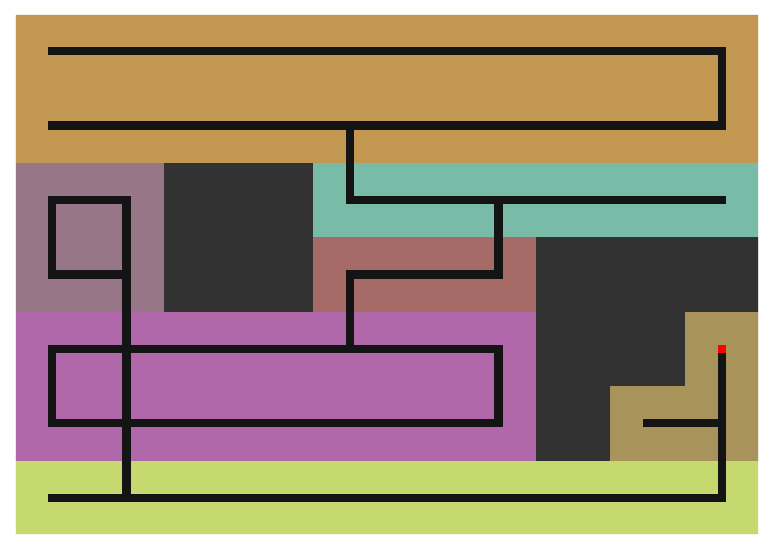

In [25]:
i = 1
# i = randint(0, len(maps) - 1)

cover(maps[i], show=True)
None

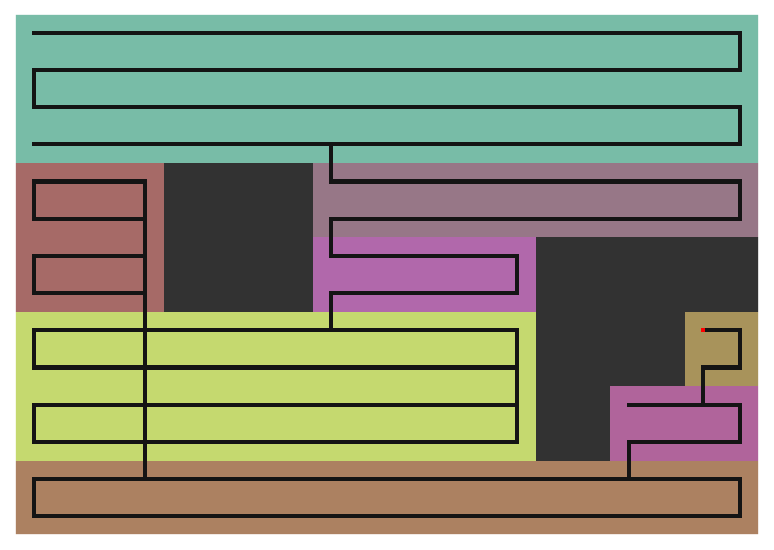

In [26]:
cover(maps[i], show=True, should_double=True)
None

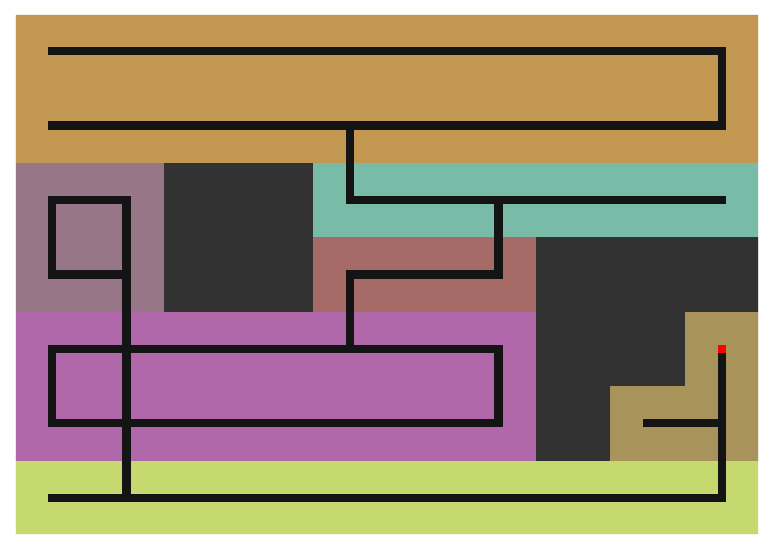

In [27]:
cover(maps[i], show=True, debug=True)
None

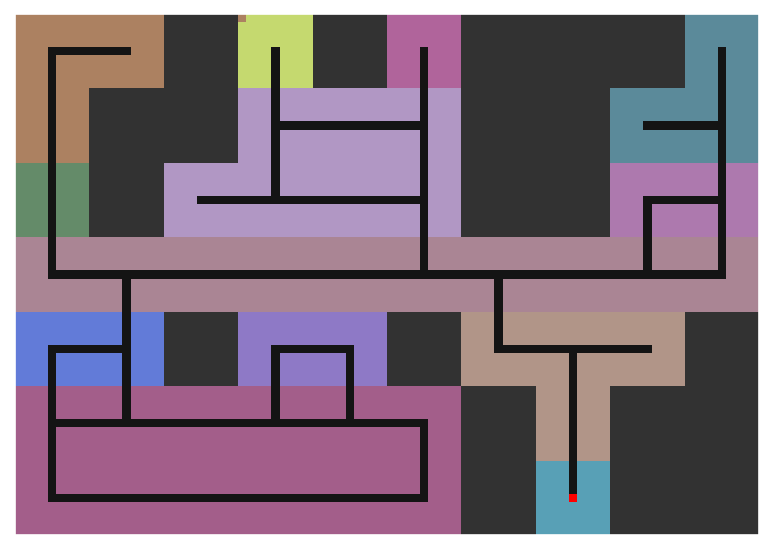

In [28]:
cover(generate_cells(covered_k=0.3, random_state=1), show=True, debug=True)
None

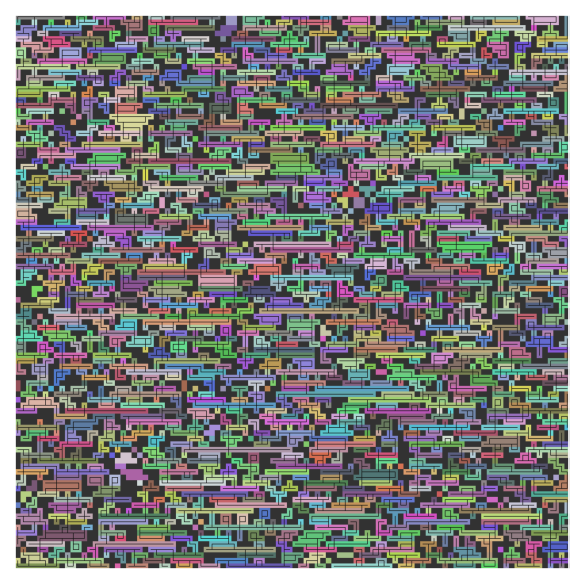

In [29]:
cover(generate_cells(covered_k=0.3, height=100, width=100, random_state=1), show=True)
None

#### BoustrophedonMapDecomposition

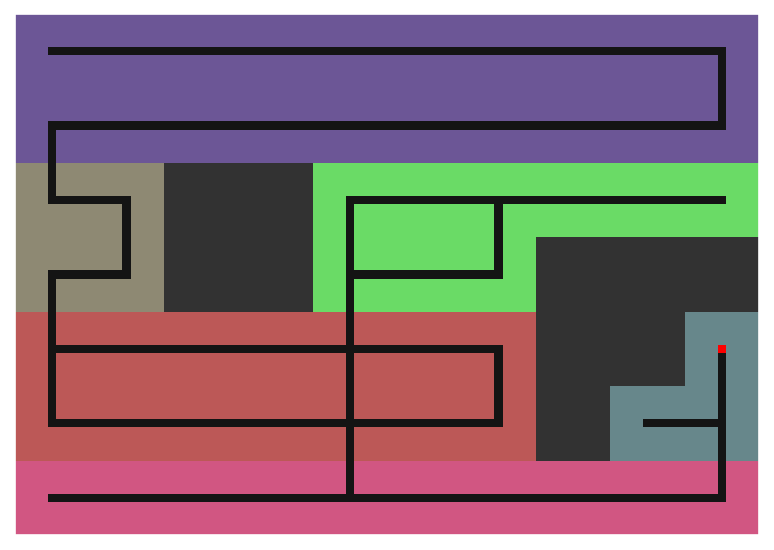

In [30]:
i = 1
# i = randint(0, len(maps) - 1)

cover(maps[i], decompositor_type=BoustrophedonMapDecomposition, show=True, debug=True)
None

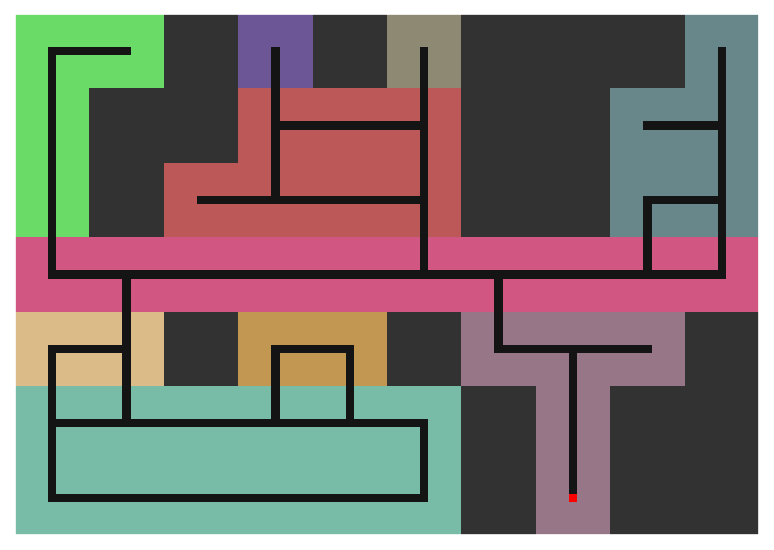

In [31]:
cover(generate_cells(covered_k=0.3, random_state=1), decompositor_type=BoustrophedonMapDecomposition, show=True, debug=True)
None

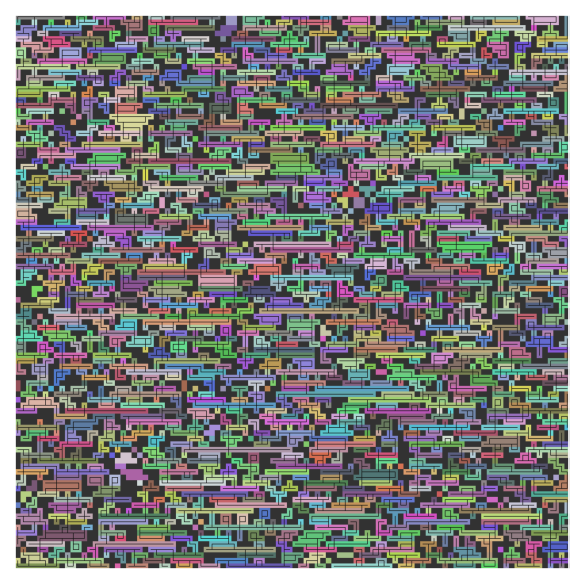

In [32]:
cover(generate_cells(covered_k=0.3, height=100, width=100, random_state=1), show=True)
None

#### Difference

In [33]:
rnd = 1

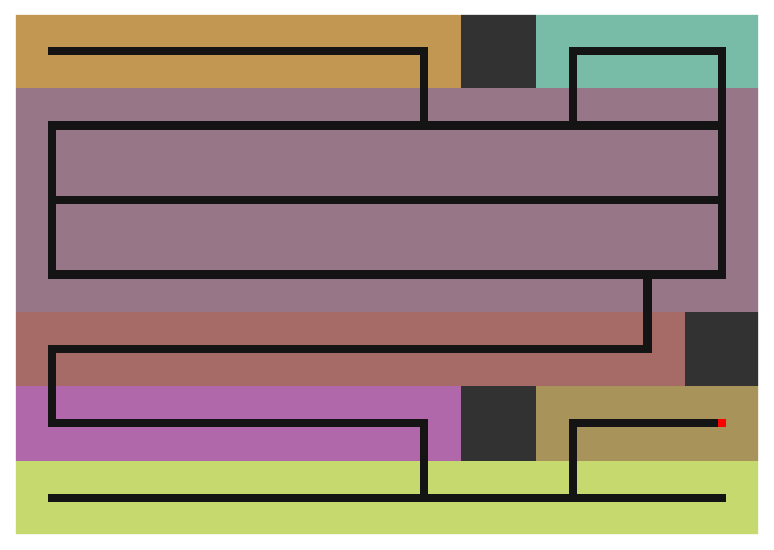

In [34]:
cover(generate_cells(covered_k=0.05, random_state=rnd), decompositor_type=TrapezoidalMapDecomposition, show=True, debug=True)
None

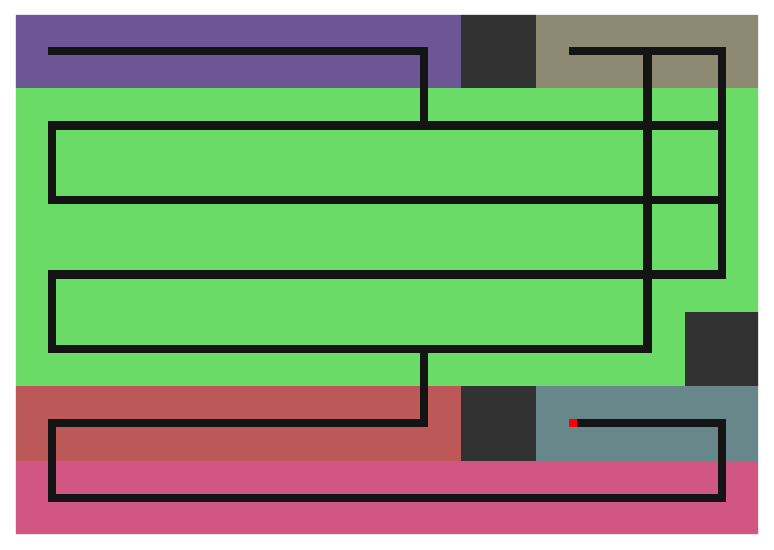

In [35]:
cover(generate_cells(covered_k=0.05, random_state=rnd), decompositor_type=BoustrophedonMapDecomposition, show=True, debug=True)
None

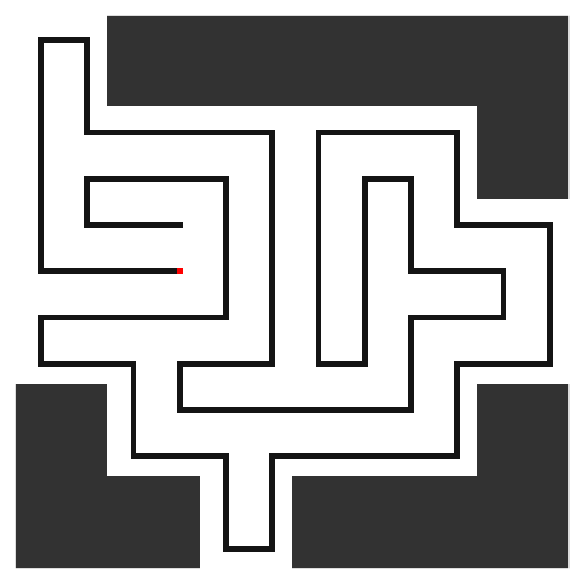

In [36]:
current_map = [
    [0, 1, 1, 1, 1, 1],
    [0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 1],
    [1, 1, 0, 1, 1, 1]
]

cover_without_decomposition(current_map, area_type=SpiralSTCArea, start=(2,1), show=True, should_double=True)
None

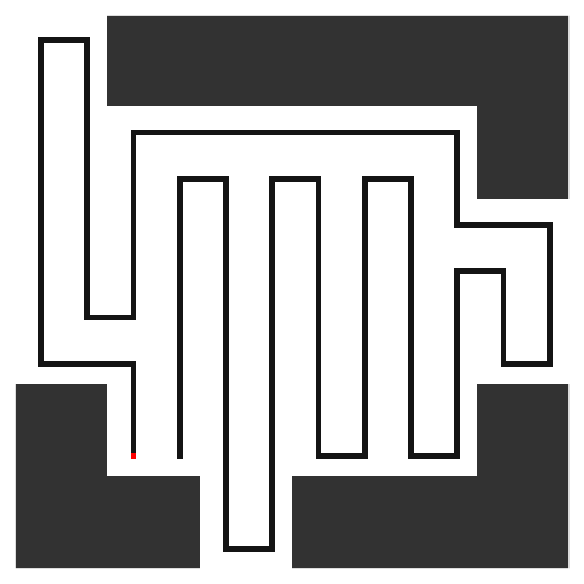

In [37]:
current_map = [
    [0, 1, 1, 1, 1, 1],
    [0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 1],
    [1, 1, 0, 1, 1, 1]
]

cover_without_decomposition(current_map, area_type=ScanSTCArea, start=(4,1), show=True, should_double=True)
None

#### Validation

In [38]:
sys.setrecursionlimit(50000)    # many nodes in validation, need for dfs    need for 500x500

too long hard validation

In [39]:
test_size = 250 # 500
kol = 25        # 100

In [40]:
%%timeit
for i in range(kol):
    assert metrics(generate_cells(covered_k=0.3, random_state=i, width=test_size, height=test_size), decompositor_type=TrapezoidalMapDecomposition)["coverage"] == 1
None

7.41 s ± 162 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [41]:
%%timeit
for i in range(kol):
    assert metrics(generate_cells(covered_k=0.3, random_state=i, width=test_size, height=test_size), decompositor_type=BoustrophedonMapDecomposition)["coverage"] == 1
None

9.32 s ± 231 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Bench

In [42]:
bench = ["bench_data/AcrosstheCape.map", "bench_data/NewYork_0_1024.map", "bench_data/w_woundedcoast.map"]
bench_start = [(0, 0), (0, 0), (19, 117)]

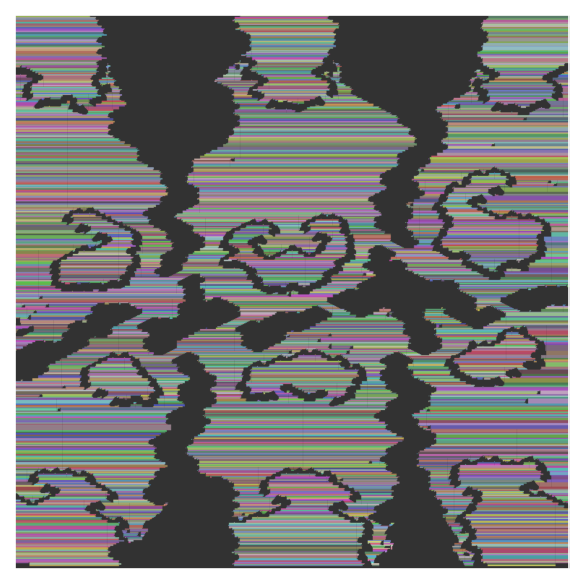

In [43]:
mapa = Map(bench[0])
cover(mapa, show=True)
None

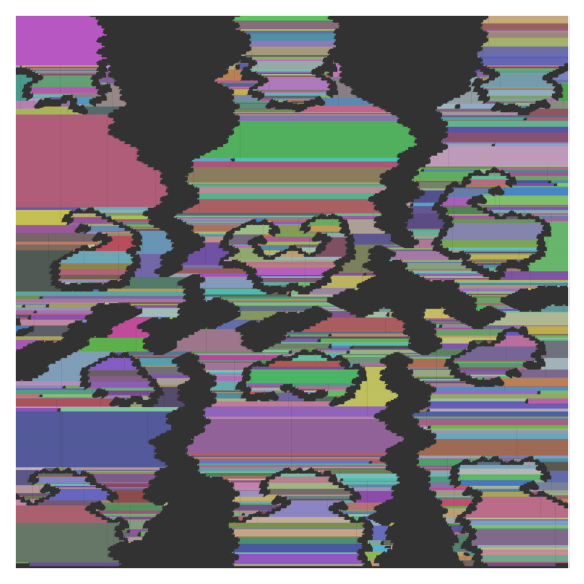

In [44]:
mapa = Map(bench[0])
start = bench_start[0]
cover(mapa, show=True, decompositor_type=BoustrophedonMapDecomposition, start=start)
None

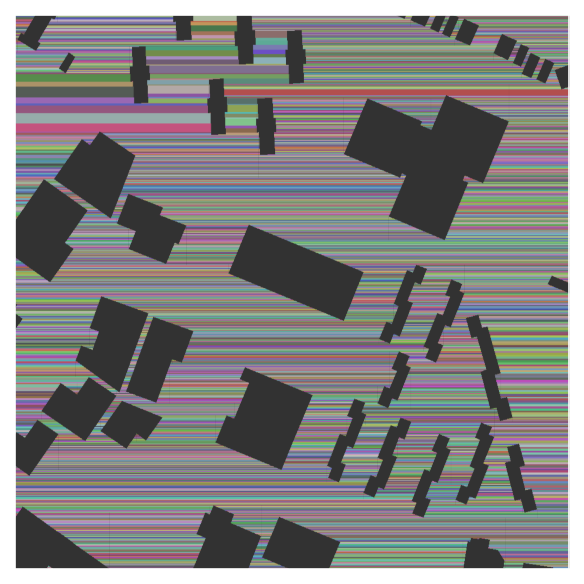

In [45]:
mapa = Map(bench[1])
cover(mapa, show=True)
None

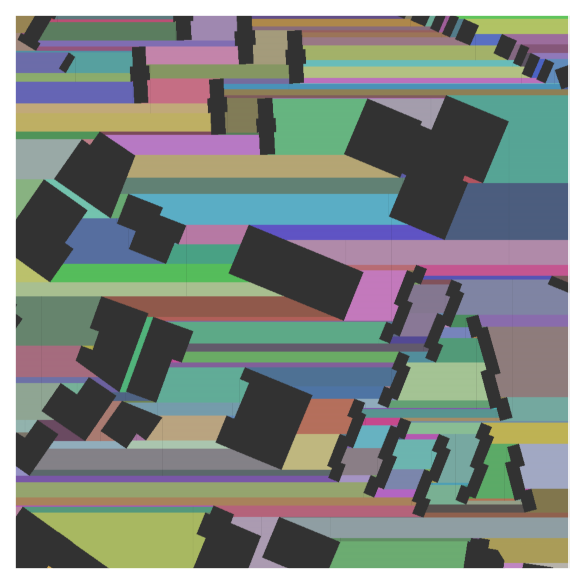

In [46]:
mapa = Map(bench[1])
start = bench_start[1]
cover(mapa, show=True, decompositor_type=BoustrophedonMapDecomposition, start=start)
None

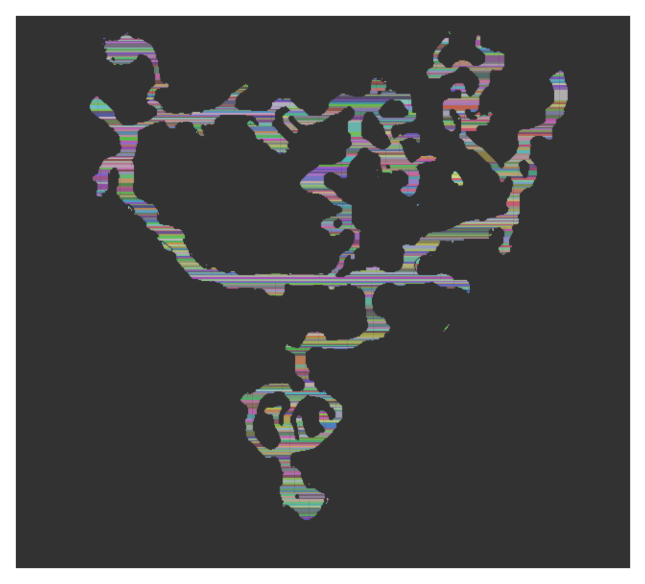

In [47]:
mapa = Map(bench[2])
cover(mapa, show=True)
None

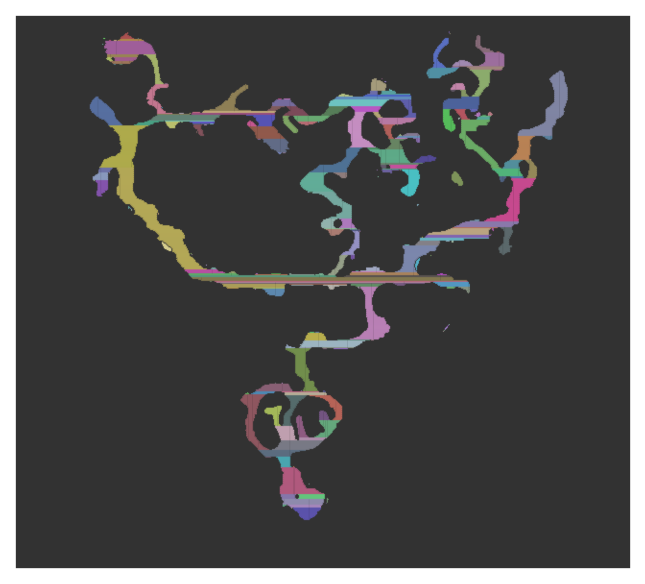

In [48]:
mapa = Map(bench[2])
start = bench_start[2]
cover(mapa, show=True, decompositor_type=BoustrophedonMapDecomposition, start=start)
None

In [49]:
sys.setrecursionlimit(10**8)    # many nodes in validation, need for dfs    need for 500x500

## Metrics

In [50]:
for i, mapa_example in enumerate(maps):
    print(i, metrics(mapa_example))

0 {'time': 0.00021982192993164062, 'length': 70, 'rotations': 12, 'coverage': 1.0}
1 {'time': 0.00024390220642089844, 'length': 80, 'rotations': 31, 'coverage': 1.0}
2 {'time': 0.00022125244140625, 'length': 82, 'rotations': 40, 'coverage': 1.0}
3 {'time': 0.00017786026000976562, 'length': 86, 'rotations': 41, 'coverage': 1.0}
4 {'time': 0.0001468658447265625, 'length': 74, 'rotations': 32, 'coverage': 1.0}


In [51]:
for i, mapa_example in enumerate(maps):
    print(i, metrics(mapa_example, decompositor_type=BoustrophedonMapDecomposition))

0 {'time': 0.000308990478515625, 'length': 70, 'rotations': 12, 'coverage': 1.0}
1 {'time': 0.0003998279571533203, 'length': 76, 'rotations': 27, 'coverage': 1.0}
2 {'time': 0.00030803680419921875, 'length': 82, 'rotations': 40, 'coverage': 1.0}
3 {'time': 0.0002810955047607422, 'length': 86, 'rotations': 41, 'coverage': 1.0}
4 {'time': 0.0002110004425048828, 'length': 70, 'rotations': 24, 'coverage': 1.0}


In [52]:
for i, name in enumerate(bench):
    start = bench_start[i]
    print(name, metrics(Map(name), start=start))

bench_data/AcrosstheCape.map {'time': 0.4363062381744385, 'length': 431726, 'rotations': 20682, 'coverage': 1.0}
bench_data/NewYork_0_1024.map {'time': 0.6589369773864746, 'length': 816638, 'rotations': 18620, 'coverage': 1.0}
bench_data/w_woundedcoast.map {'time': 0.05759000778198242, 'length': 41726, 'rotations': 6995, 'coverage': 1.0}


In [53]:
for i, name in enumerate(bench):
    start = bench_start[i]
    print(name, metrics(Map(name), decompositor_type=BoustrophedonMapDecomposition, start=start))

bench_data/AcrosstheCape.map {'time': 0.9411823749542236, 'length': 433382, 'rotations': 20732, 'coverage': 1.0}
bench_data/NewYork_0_1024.map {'time': 1.74503493309021, 'length': 818642, 'rotations': 18096, 'coverage': 1.0}
bench_data/w_woundedcoast.map {'time': 0.08495497703552246, 'length': 42142, 'rotations': 7203, 'coverage': 1.0}


## Tables, Graphics

In [54]:
max_size = 500  # if everything falls down, you can simplify, make the number smaller, for example 200

sizes = []
trapezoidal_metrics = []
boustrophedon_metrics = []
spiral_stc_metrics = []
scan_stc_metrics = []
for i in range(10, max_size, 10):
    for j in range(5):
        current_map = generate_cells(covered_k=0.3, random_state=j, height=i, width=i)
        start = (0, 0)
        trapezoidal_metric = metrics(current_map, decompositor_type=TrapezoidalMapDecomposition, start=(0,0), should_double=True)
        boustrophedon_metric = metrics(current_map, decompositor_type=BoustrophedonMapDecomposition, start=(0,0), should_double=True)
        spiral_stc_metric = metrics_without_decomposition(current_map, area_type=SpiralSTCArea, start=start, should_double=True)
        scan_stc_metric = metrics_without_decomposition(current_map, area_type=ScanSTCArea, start=start, should_double=True)
        if j == 0:
            sizes.append(i)
            trapezoidal_metrics.append(trapezoidal_metric)
            boustrophedon_metrics.append(boustrophedon_metric)
            spiral_stc_metrics.append(spiral_stc_metric)
            scan_stc_metrics.append(scan_stc_metric)
        else:
            for metric in ['time', 'length', 'rotations', 'coverage']:
                trapezoidal_metrics[-1][metric] = max(trapezoidal_metrics[-1][metric], trapezoidal_metric[metric])
                boustrophedon_metrics[-1][metric] = max(boustrophedon_metrics[-1][metric], boustrophedon_metric[metric])
                spiral_stc_metrics[-1][metric] = max(spiral_stc_metrics[-1][metric], spiral_stc_metric[metric])
                scan_stc_metrics[-1][metric] = max(scan_stc_metrics[-1][metric], scan_stc_metric[metric])

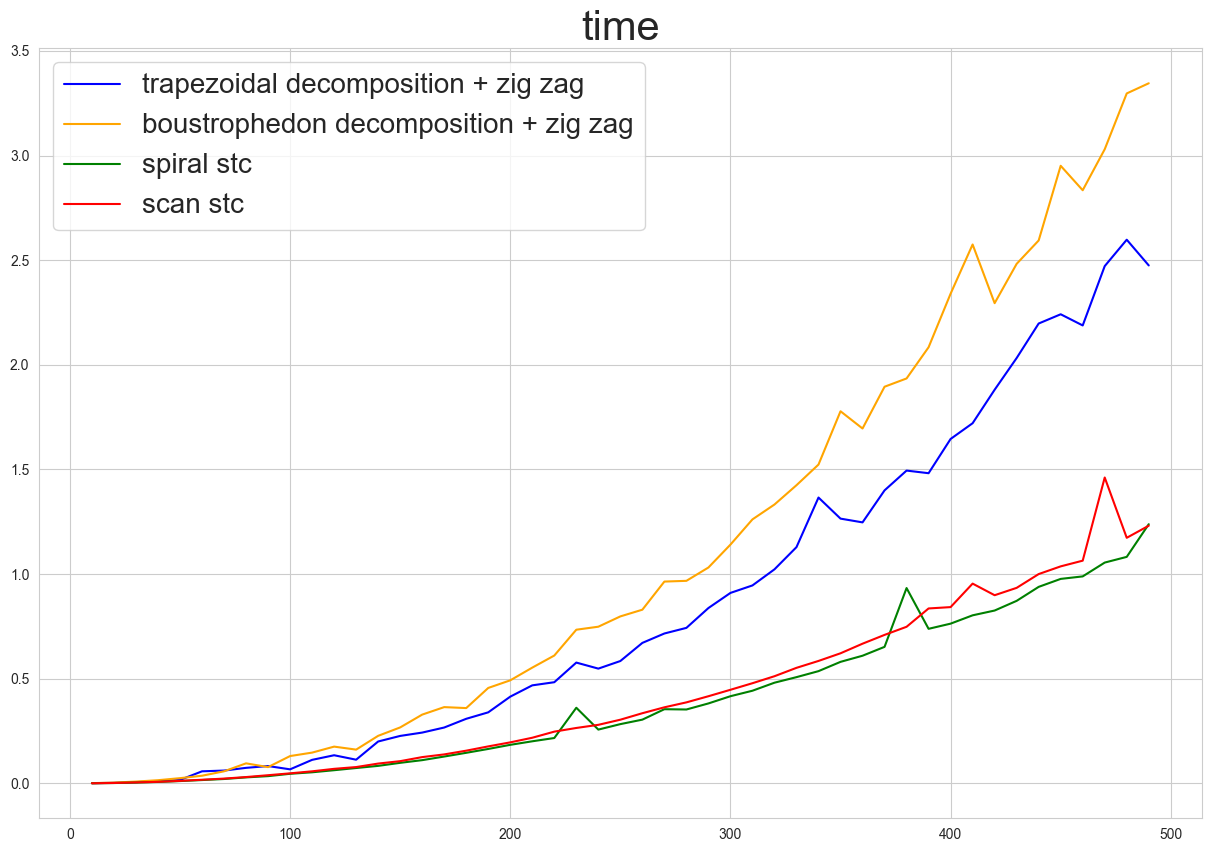

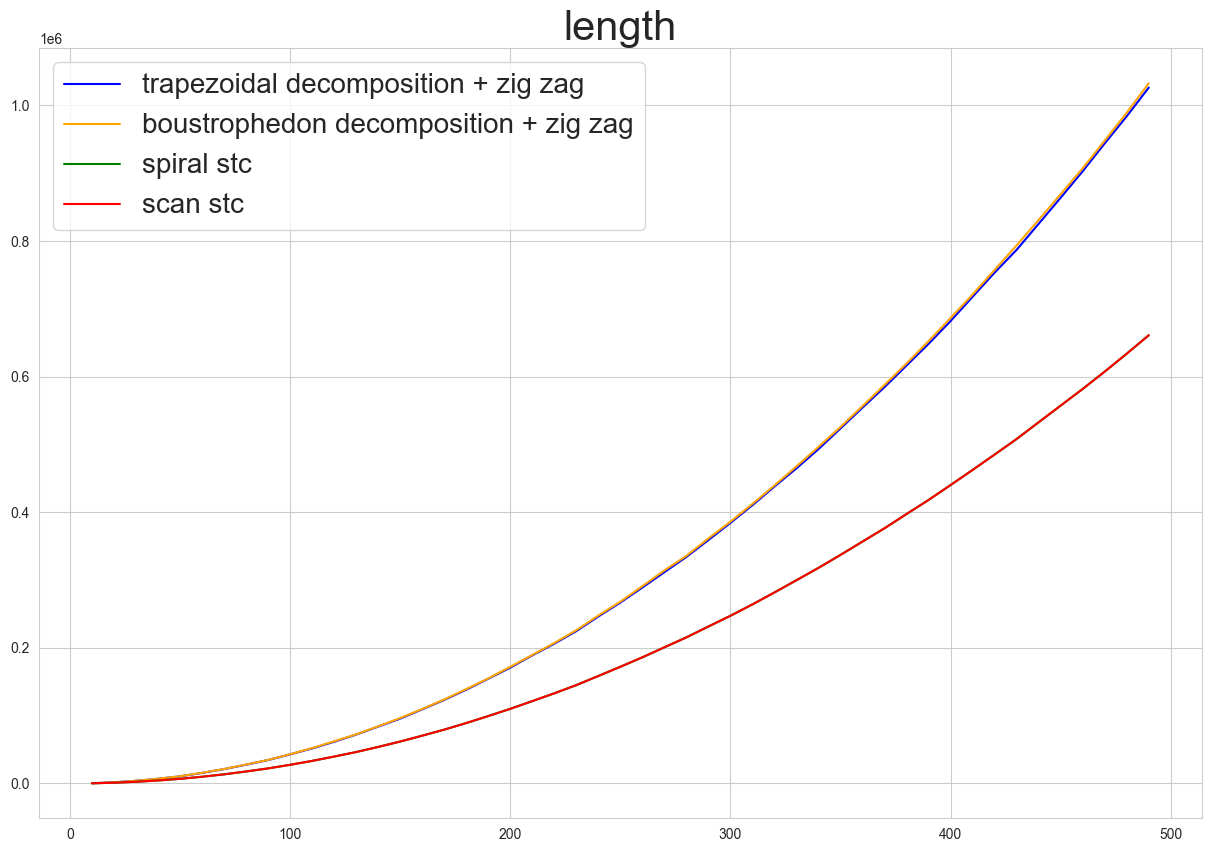

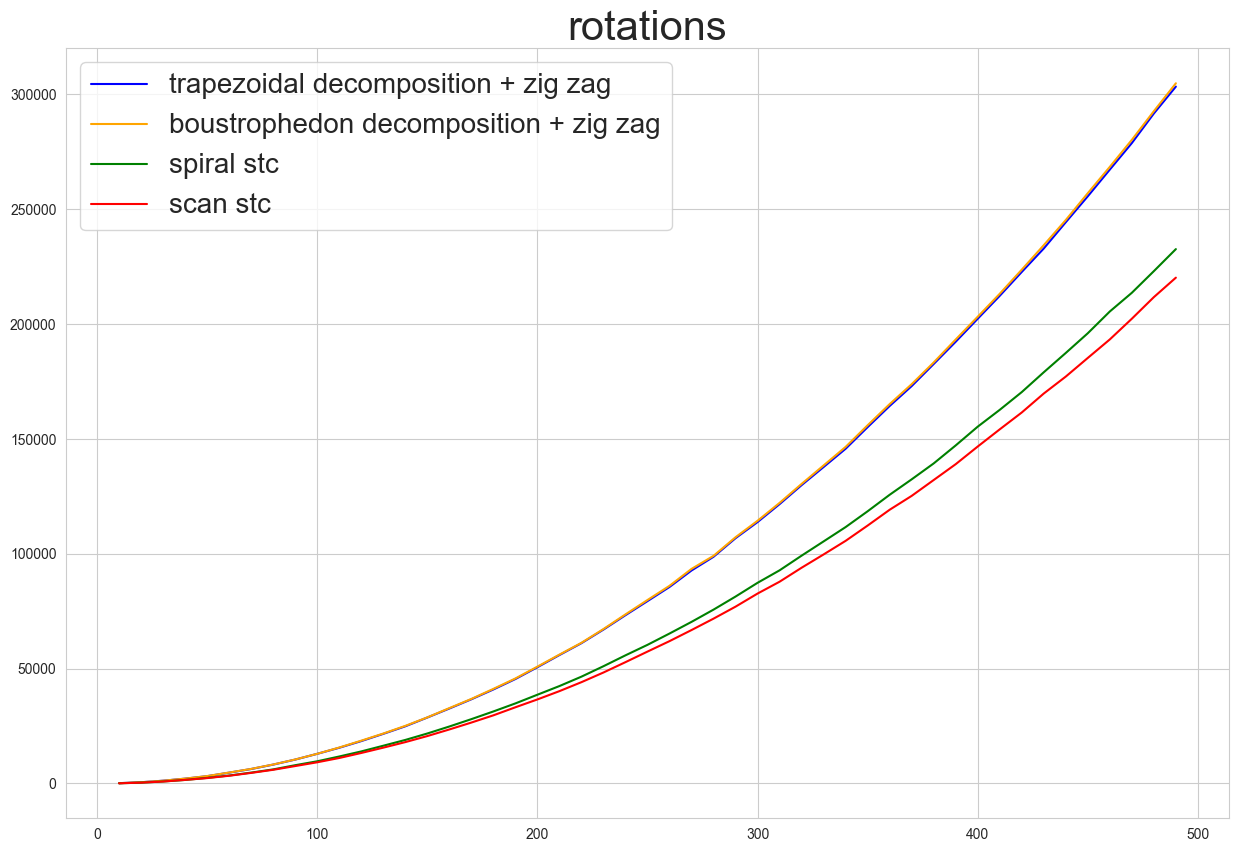

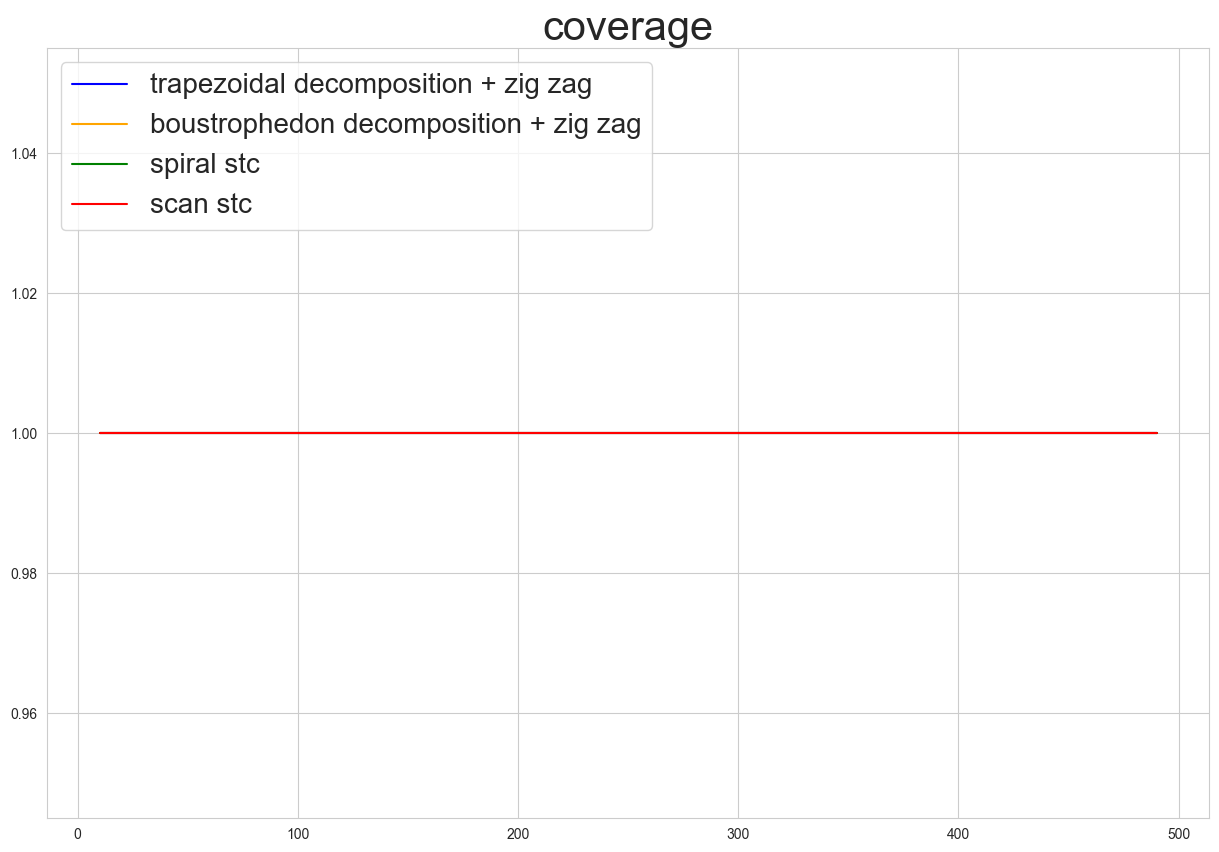

In [55]:
for metric in ['time', 'length', 'rotations', 'coverage']:
    trapezoidal = []
    boustrophedon = []
    spiral_stc = []
    scan_stc = []
    for i in range(len(sizes)):
        trapezoidal.append(trapezoidal_metrics[i][metric])
        boustrophedon.append(boustrophedon_metrics[i][metric])
        spiral_stc.append(spiral_stc_metrics[i][metric])
        scan_stc.append(scan_stc_metrics[i][metric])
    sns.set_style('whitegrid')
    plt.figure(figsize=(15, 10))
    plt.title(f'{metric}', fontsize=30)
    plt.plot(sizes, trapezoidal, color='blue', label='trapezoidal decomposition + zig zag')
    plt.plot(sizes, boustrophedon, color='orange', label='boustrophedon decomposition + zig zag')
    plt.plot(sizes, spiral_stc, color='green', label='spiral stc')
    plt.plot(sizes, scan_stc, color='red', label='scan stc')
    plt.legend(loc=2, fontsize=20)
    plt.show()

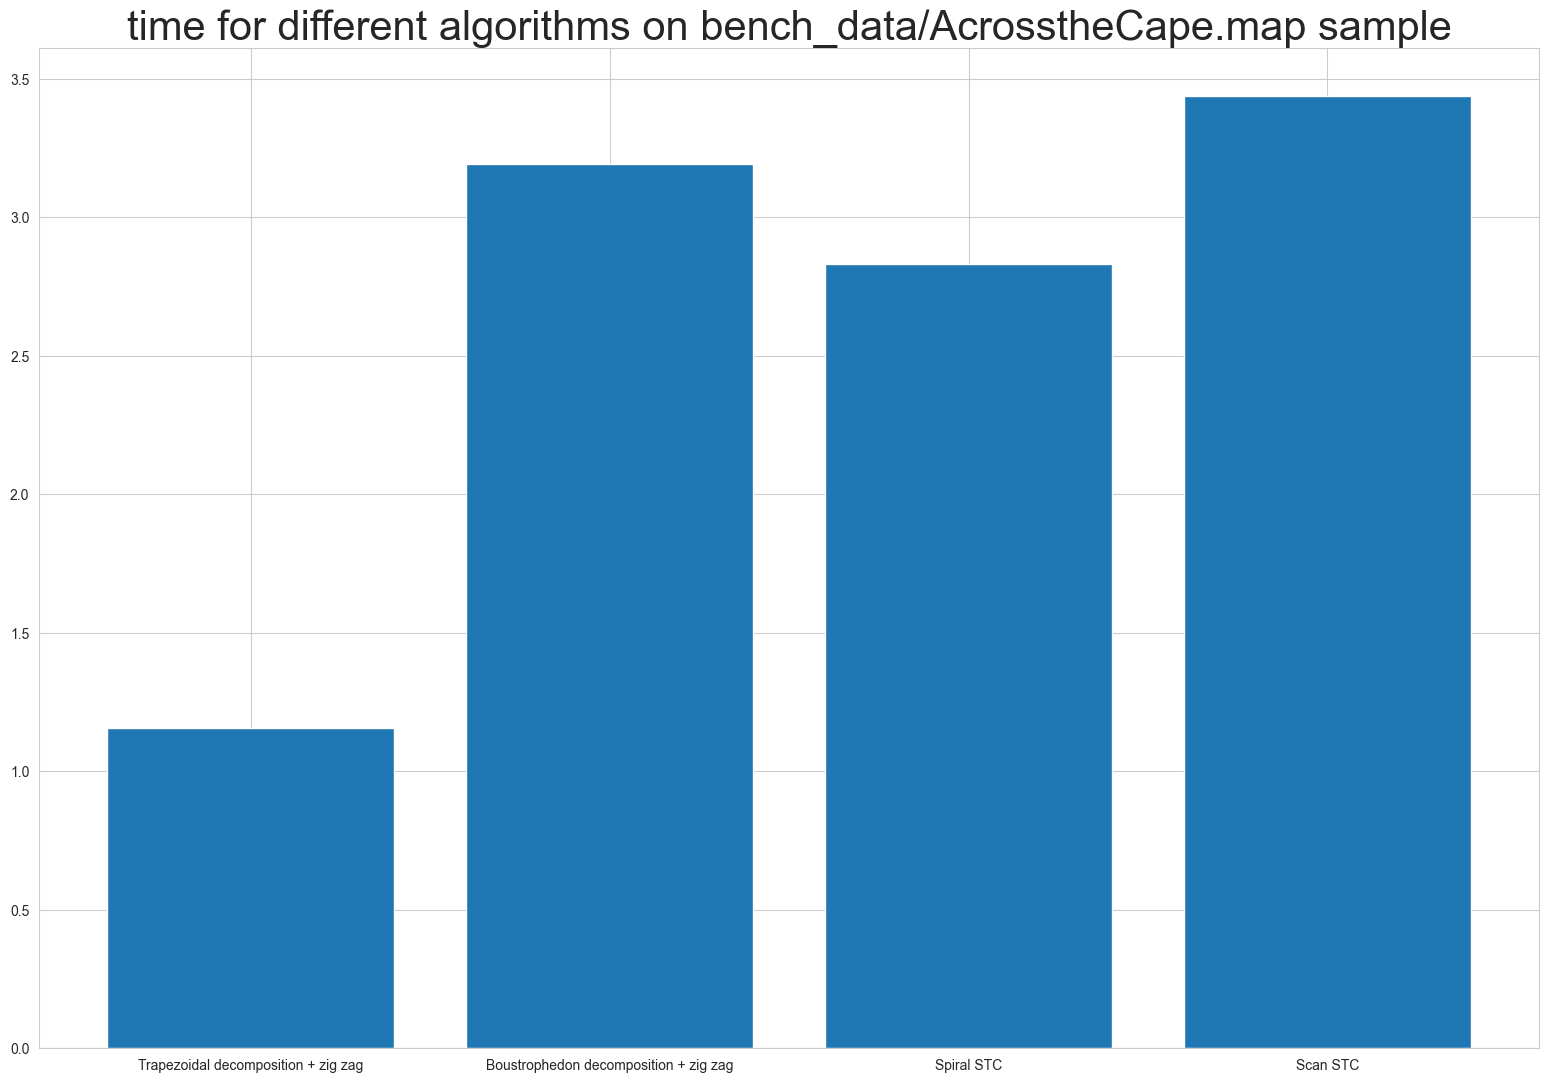

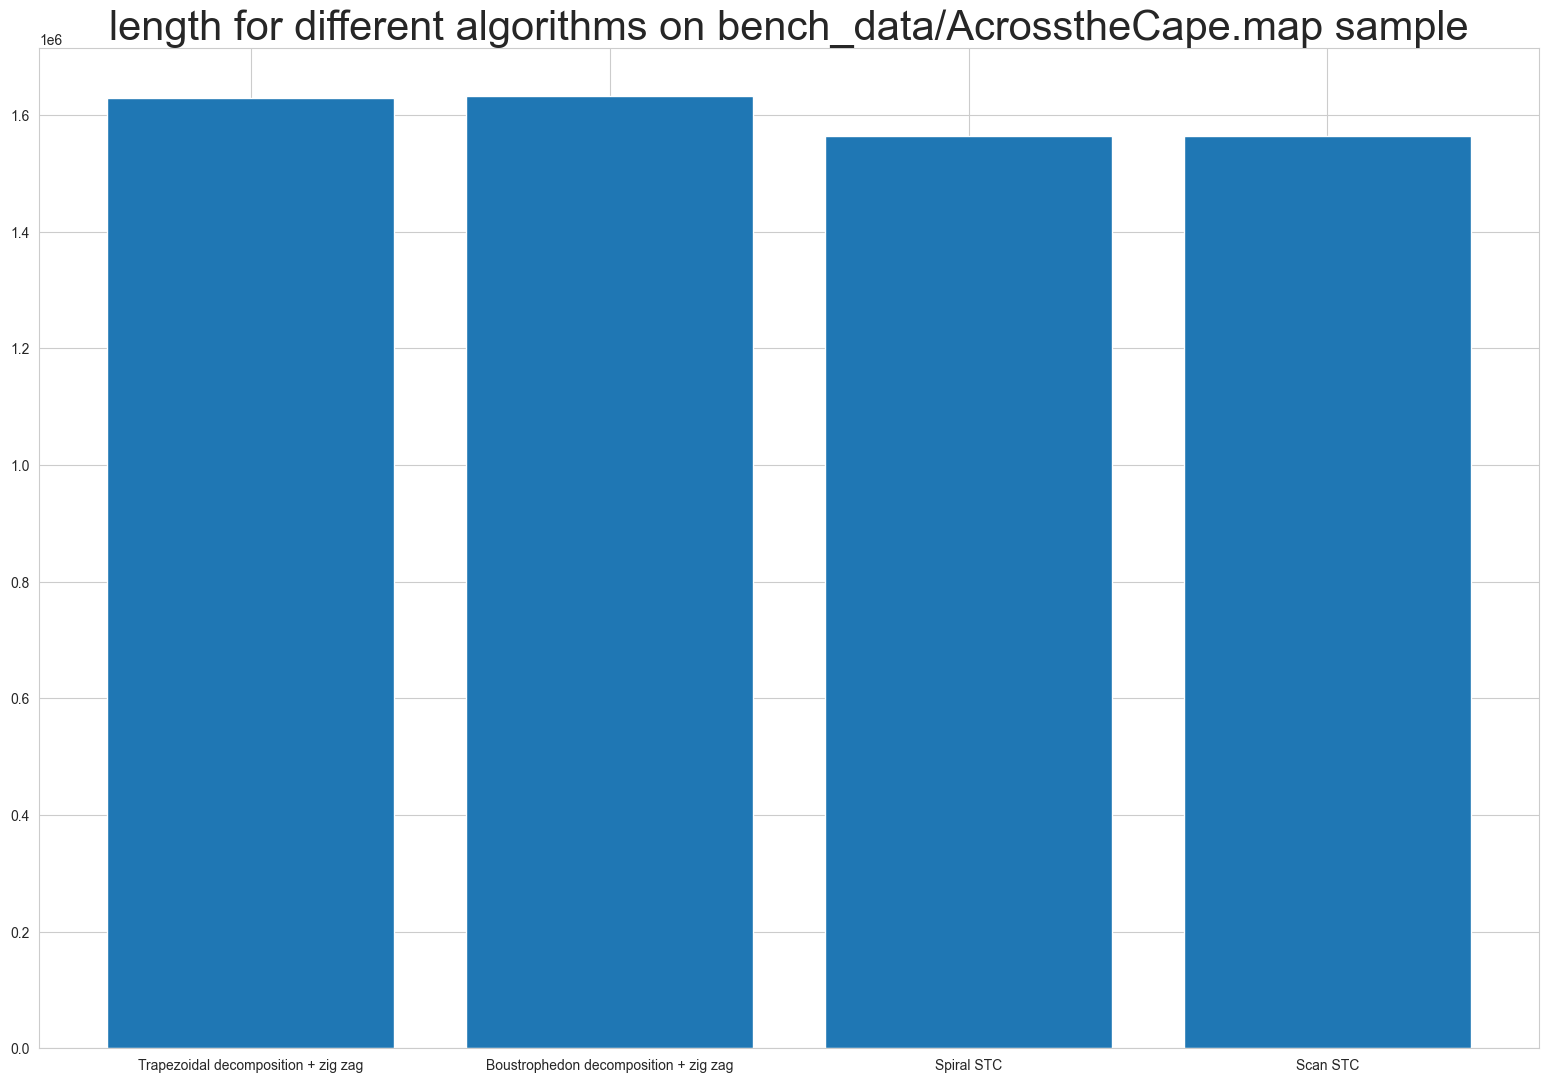

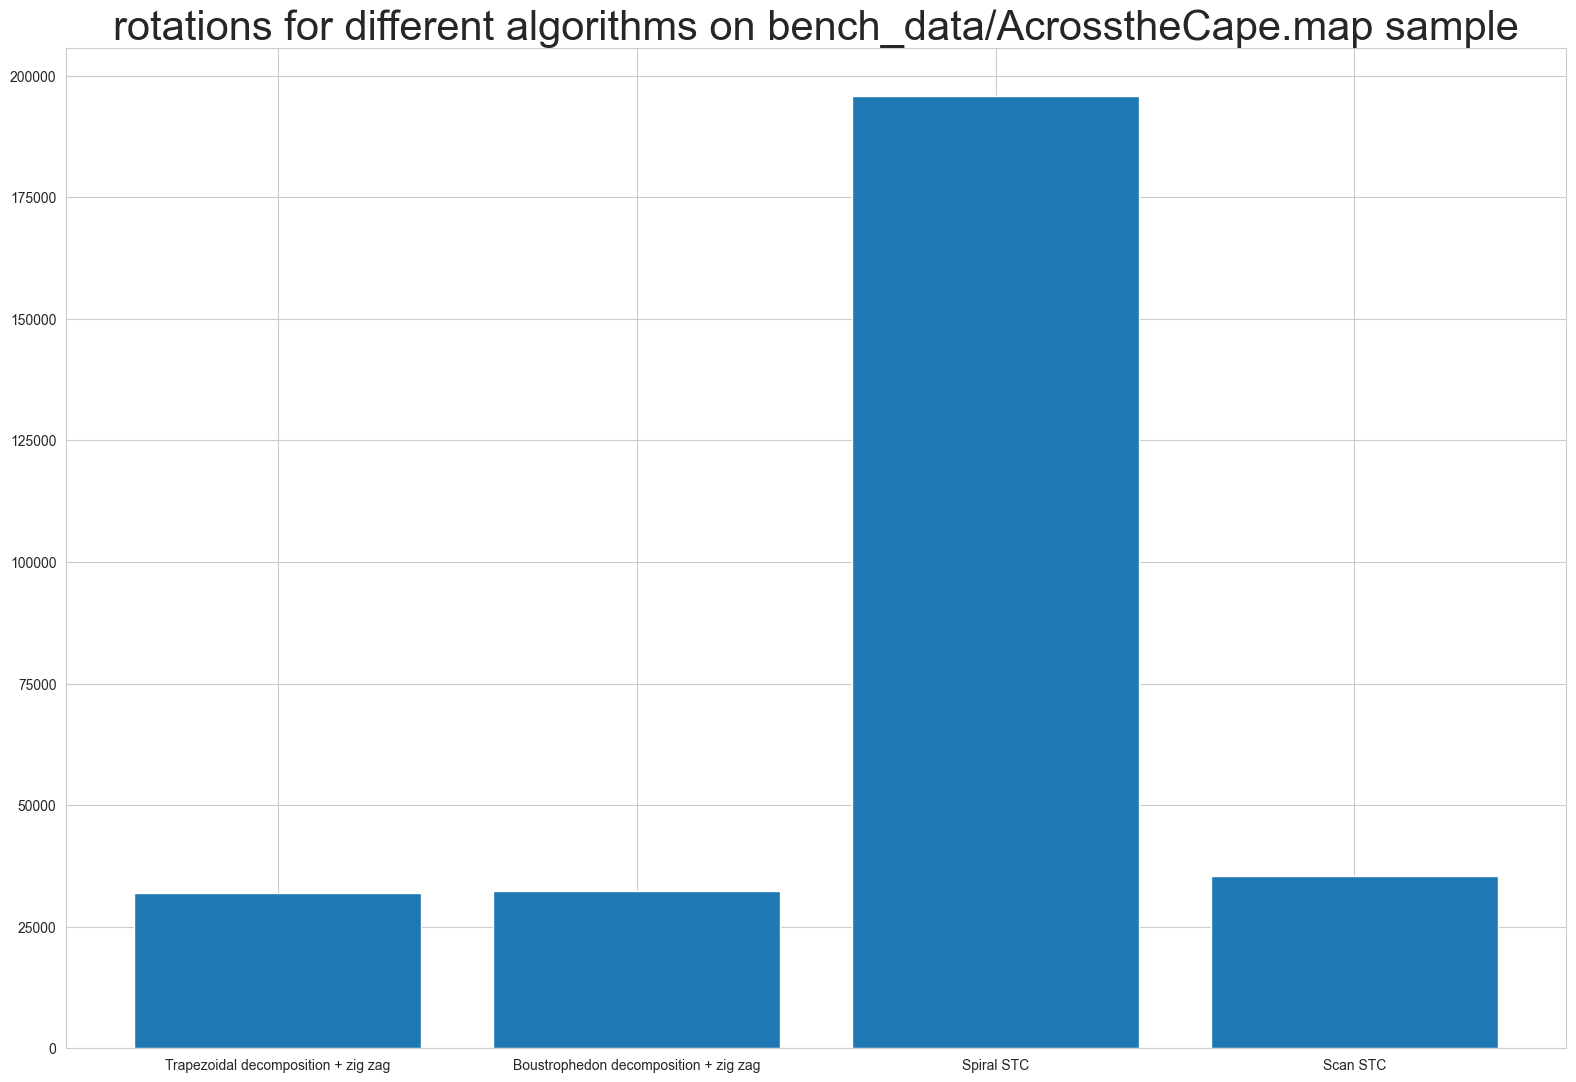

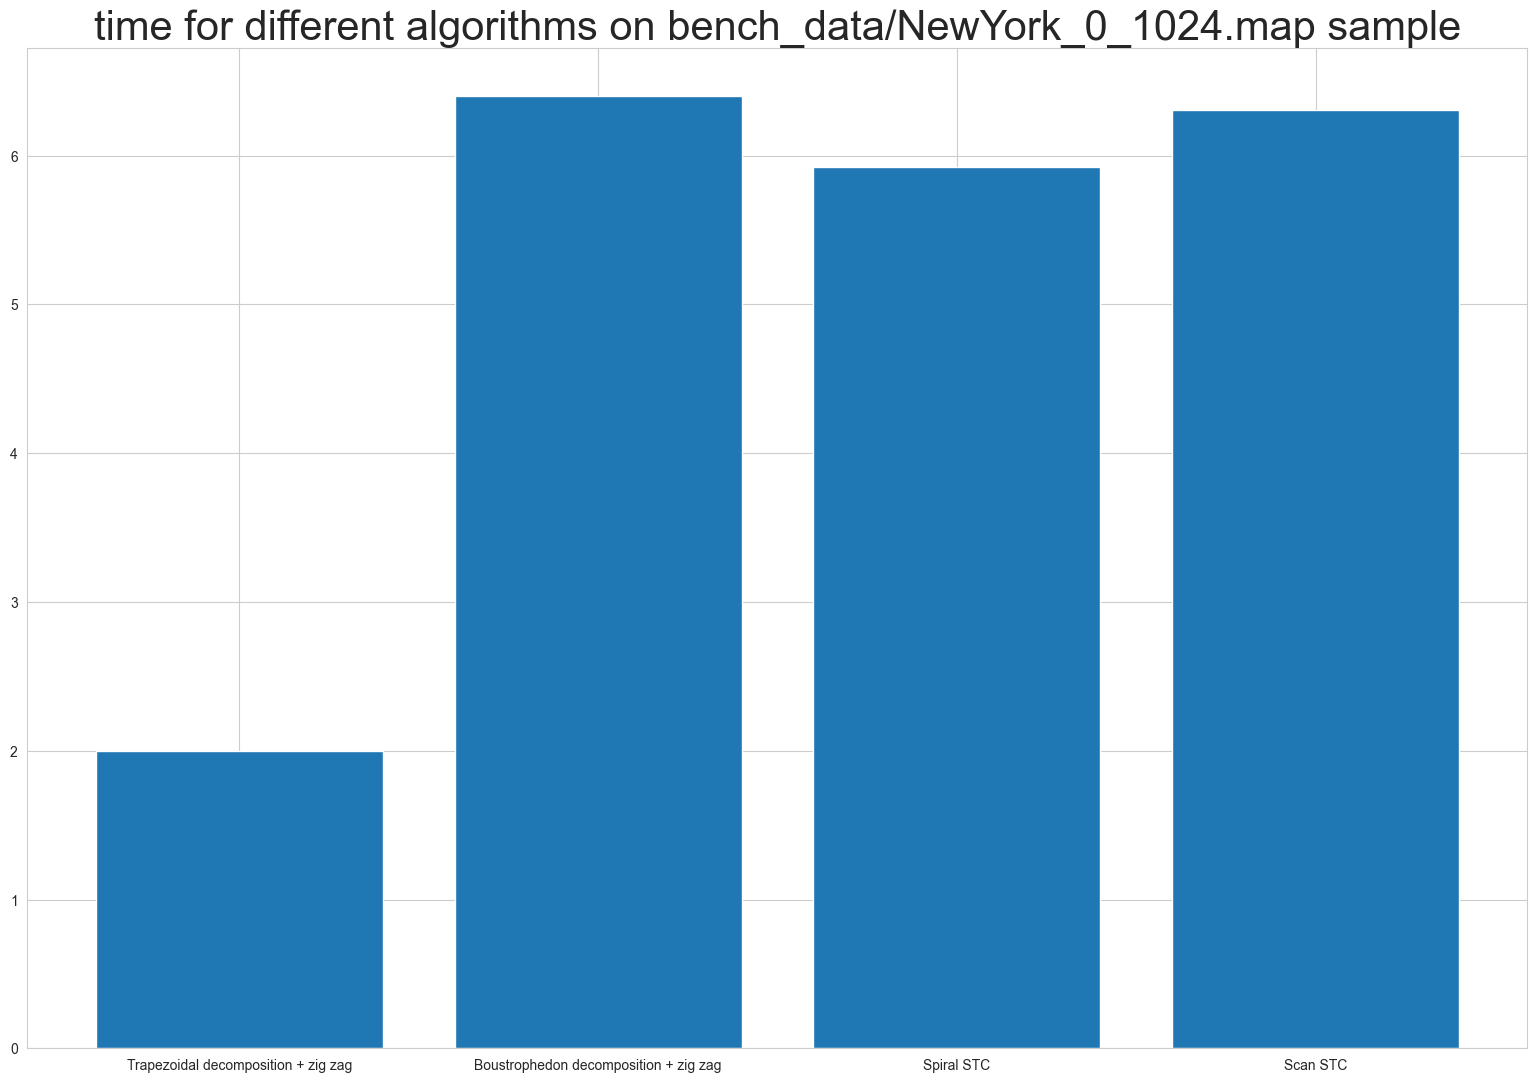

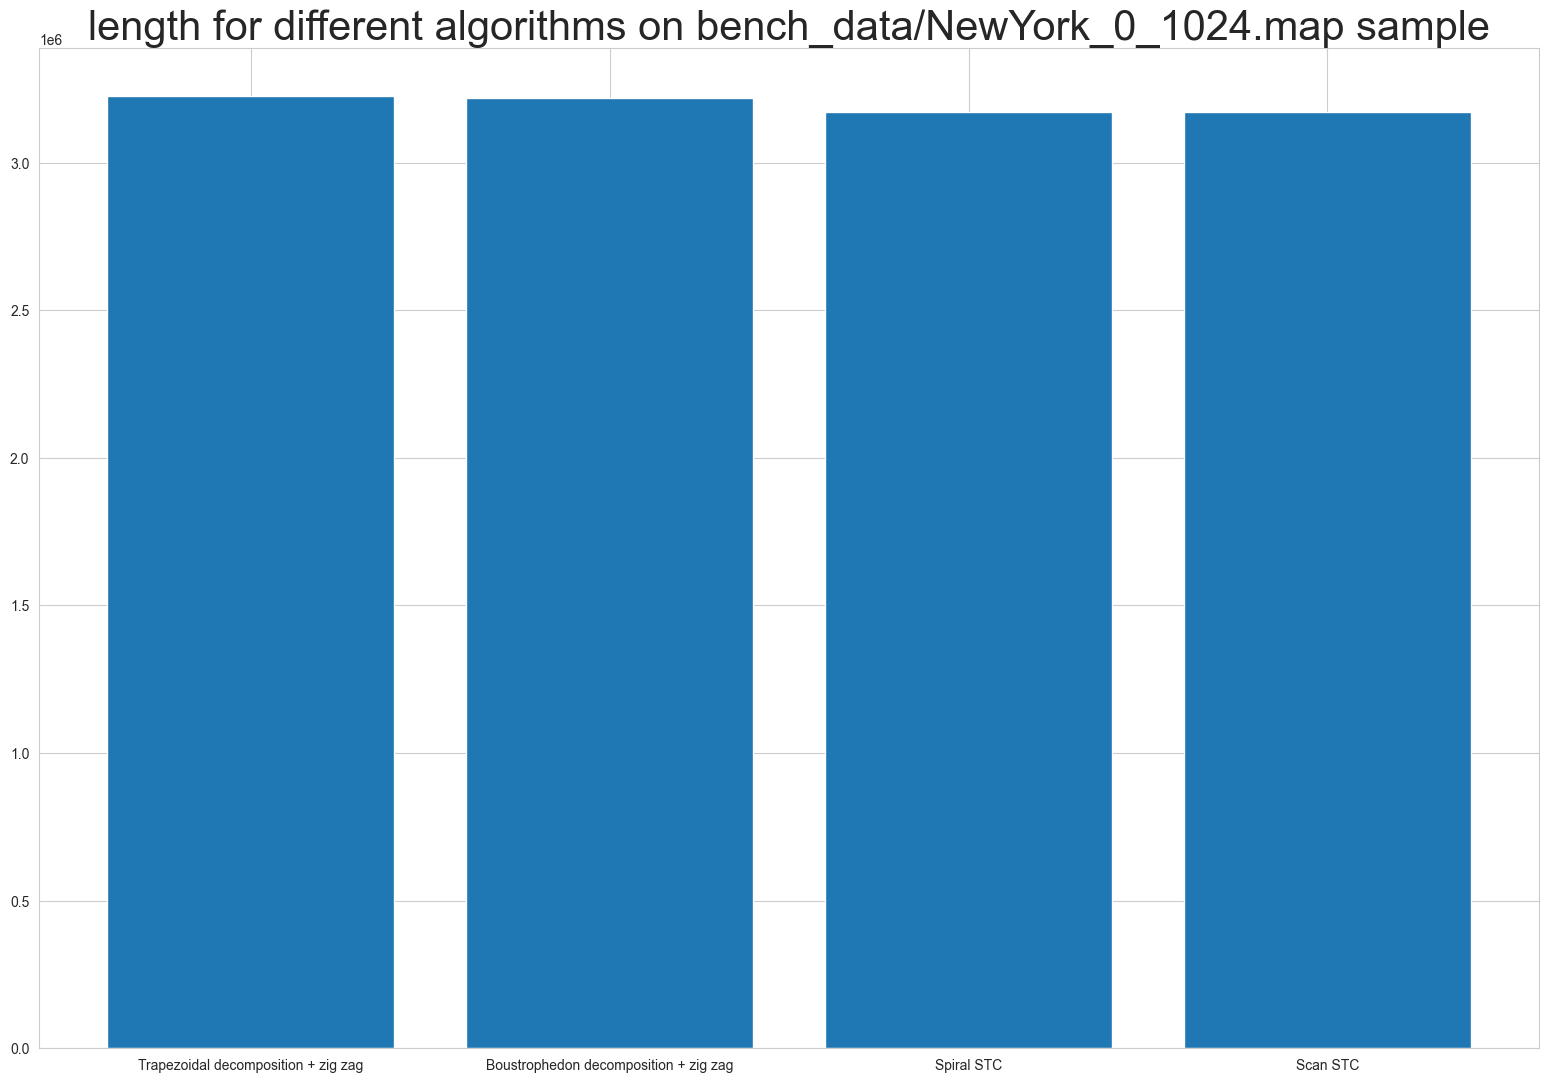

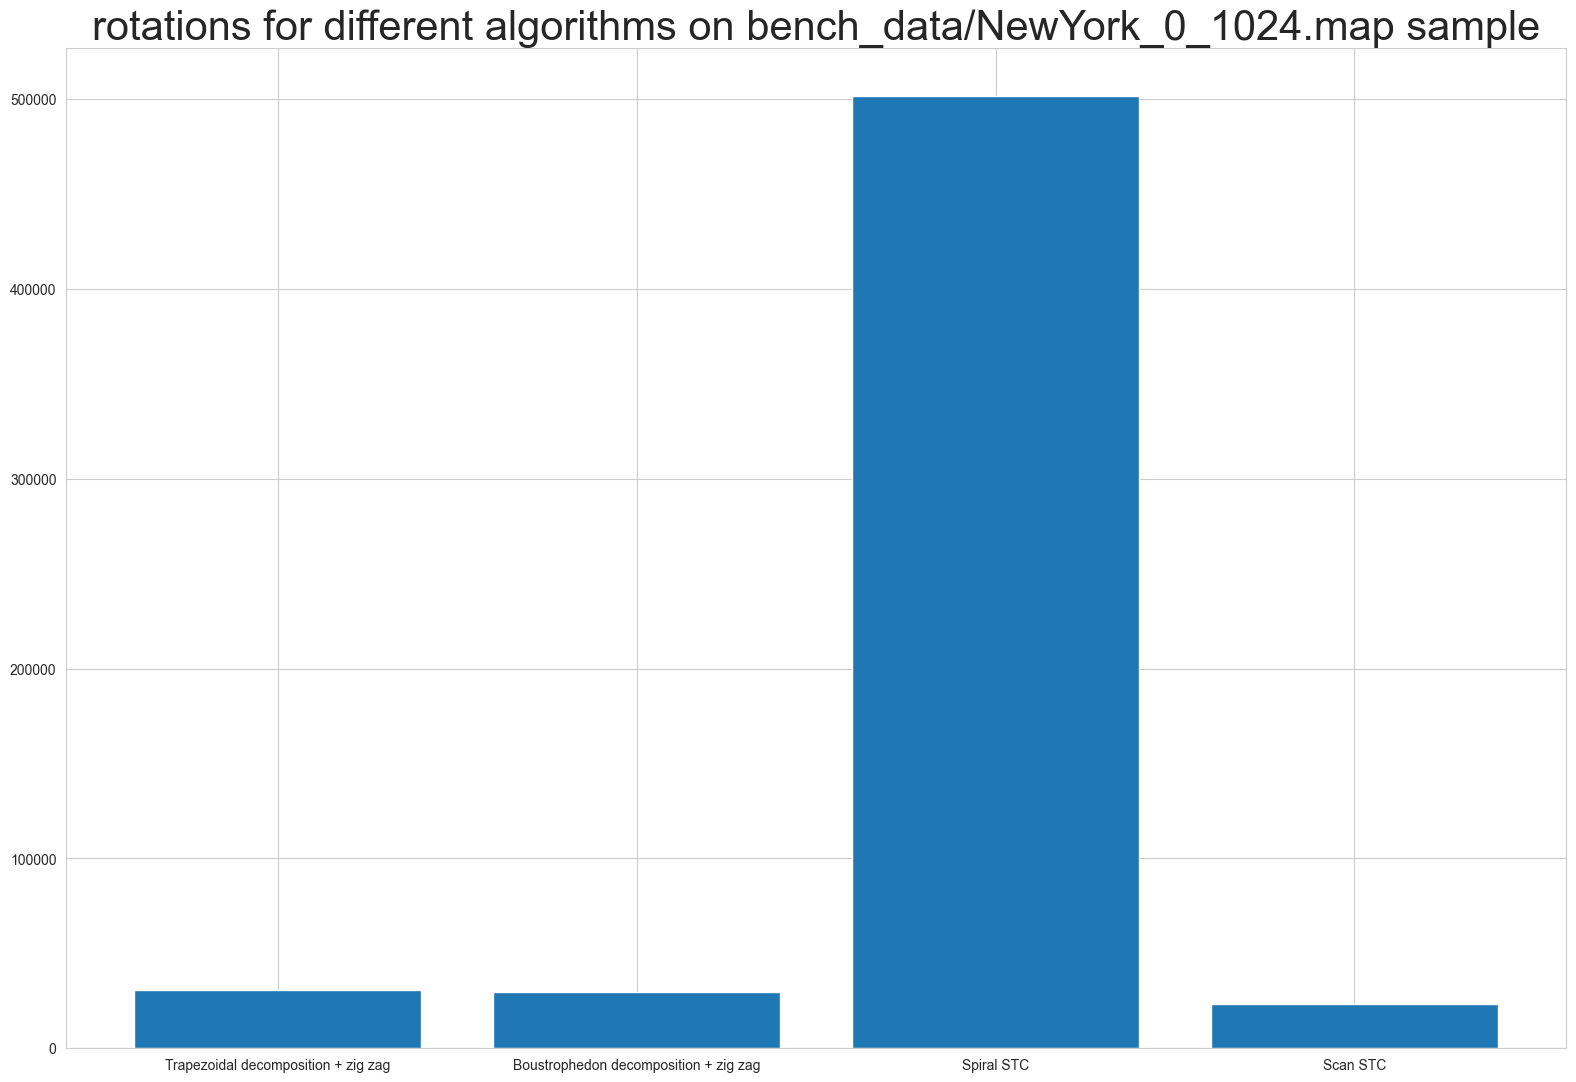

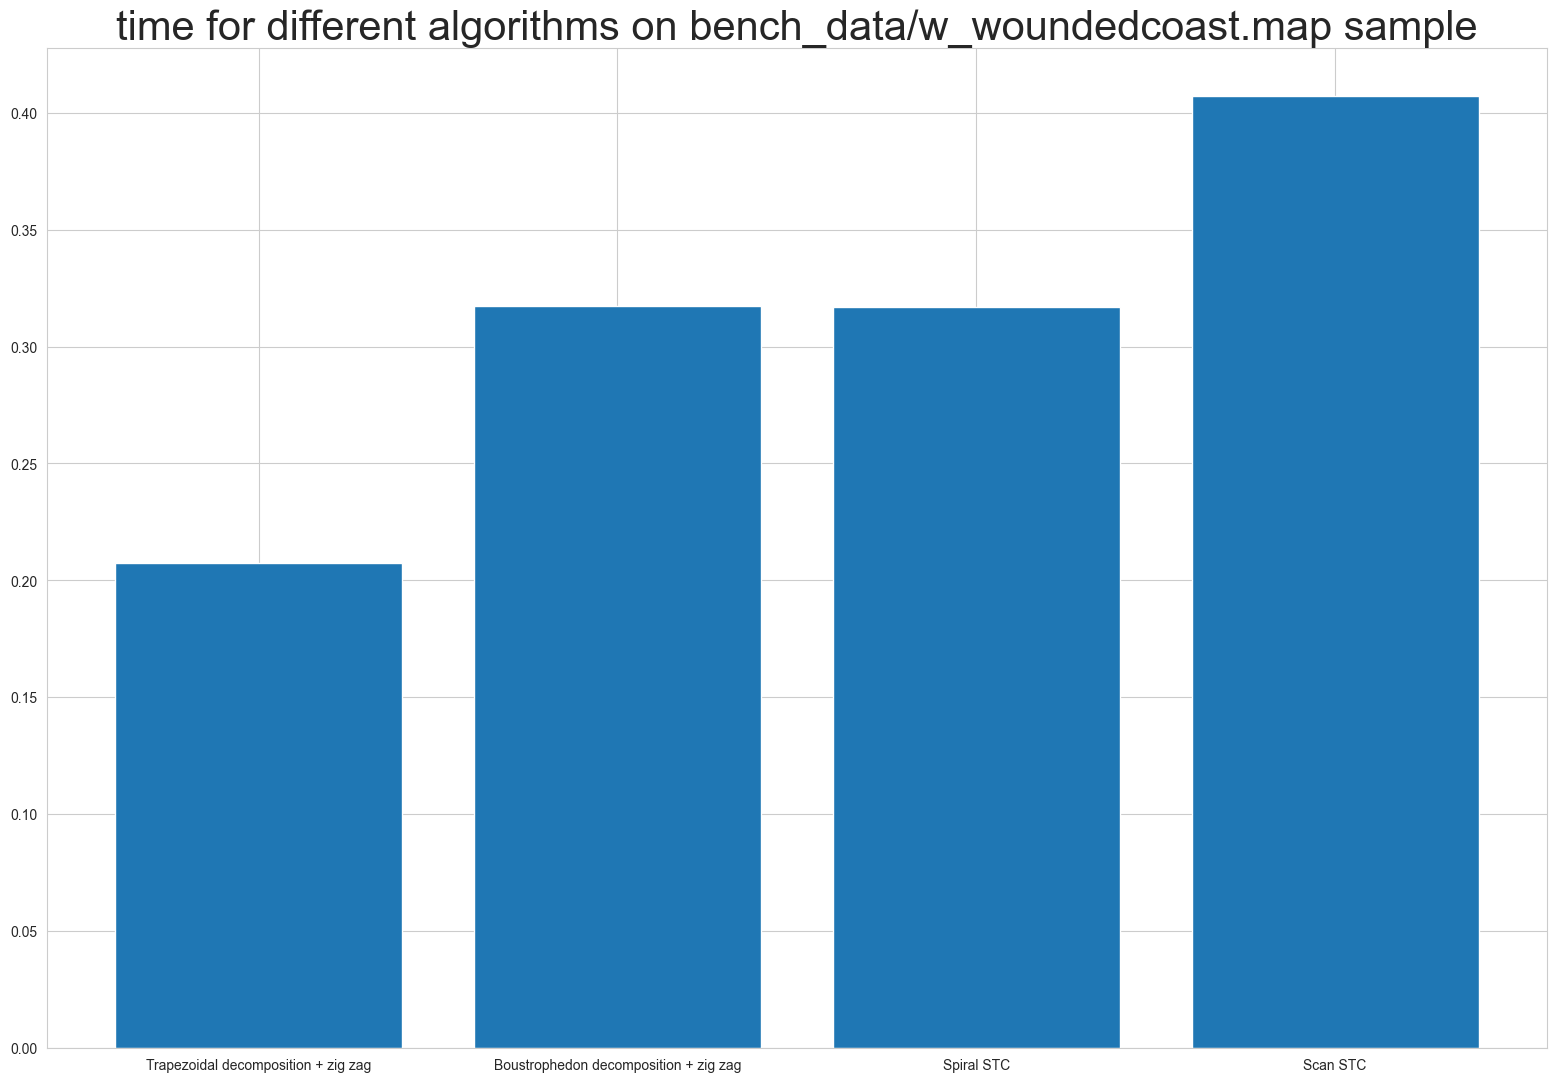

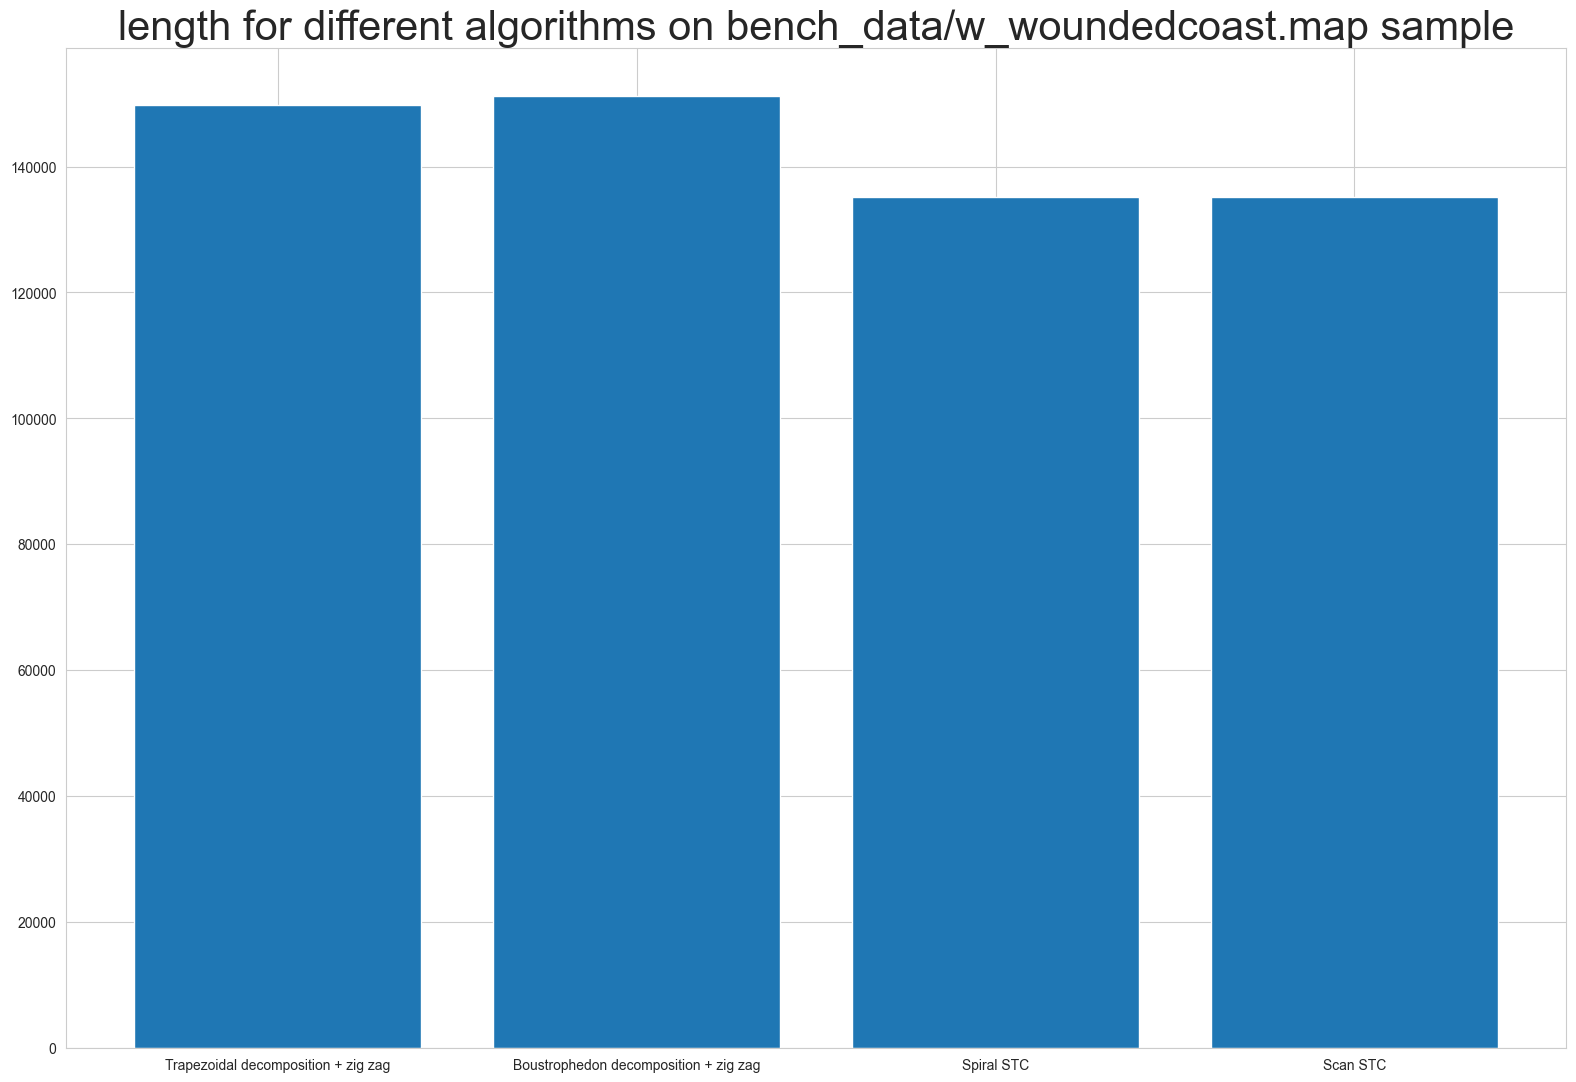

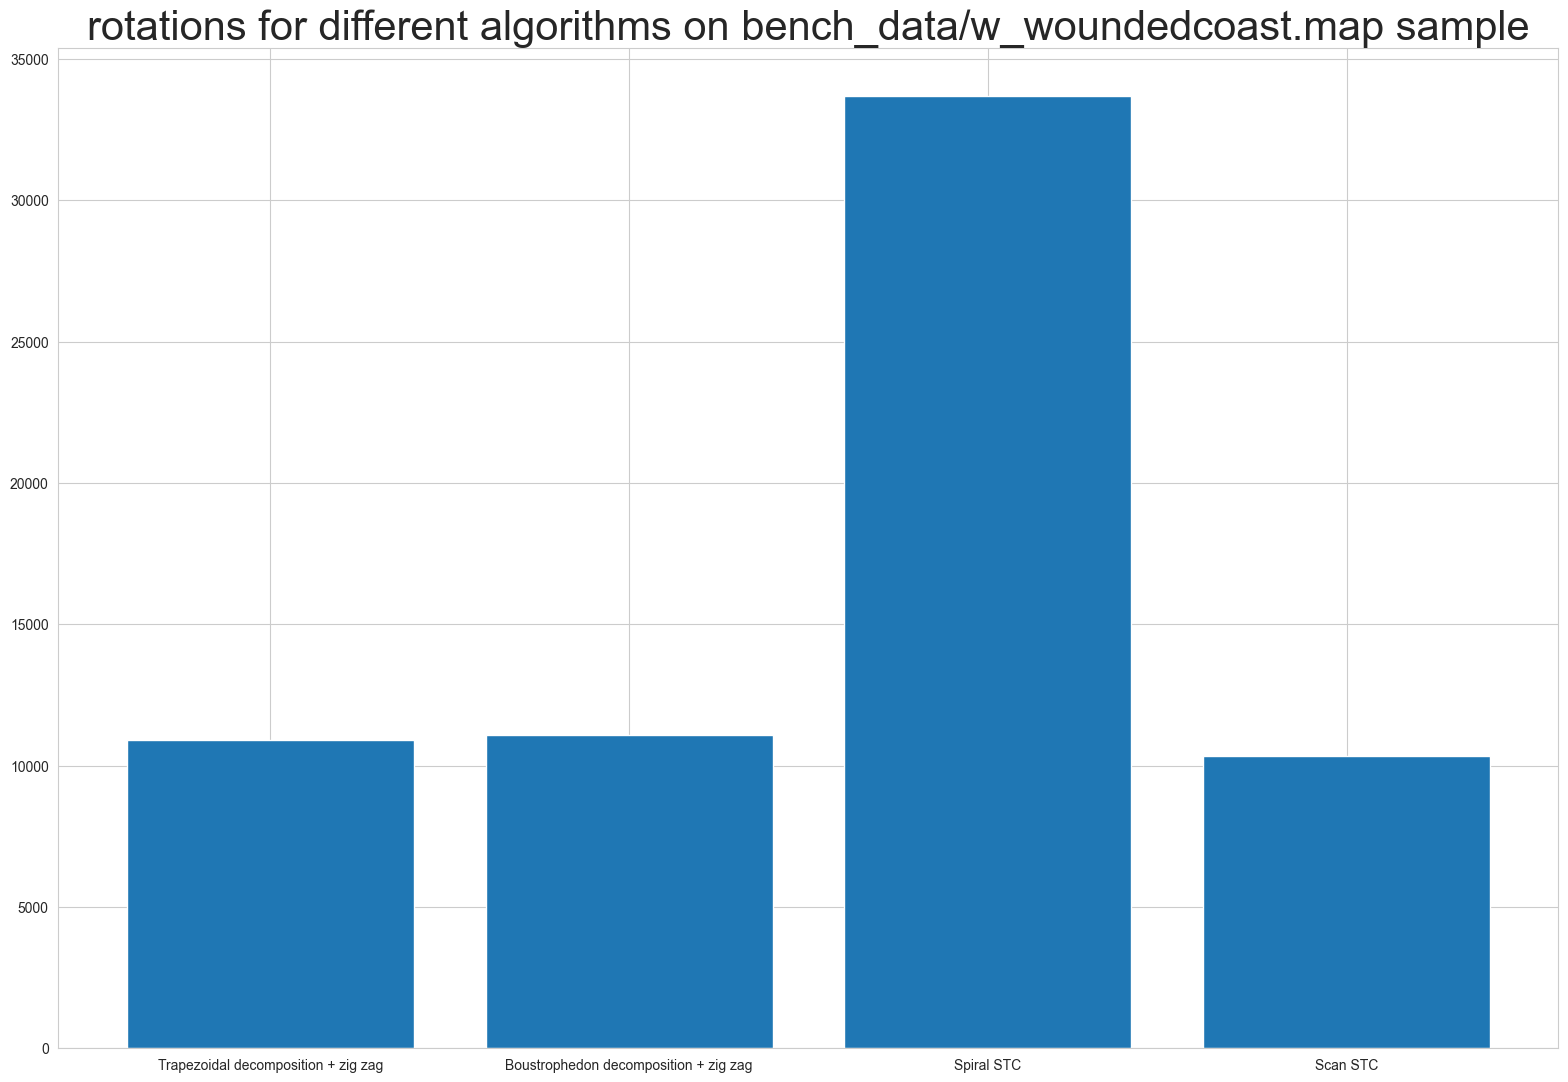

In [56]:
for i, name in enumerate(bench):
    start = bench_start[i]
    double_start = (2 * start[0], 2 * start[1])
    trapezoidal_metric = metrics(Map(name), decompositor_type=TrapezoidalMapDecomposition, start=double_start, should_double=True)
    boustrophedon_metric = metrics(Map(name), decompositor_type=BoustrophedonMapDecomposition, start=double_start, should_double=True)
    spiral_stc_metric = metrics_without_decomposition(Map(name), area_type=SpiralSTCArea, start=start, should_double=True)
    scan_stc_metric = metrics_without_decomposition(Map(name), area_type=ScanSTCArea, start=start, should_double=True)
    
    for metric in ['time', 'length', 'rotations']:
        fig = plt.figure(figsize=(15, 10))
        ax = fig.add_axes([0, 0, 1, 1])
        ax.set_title(f'{metric} for different algorithms on {name} sample', fontsize=30)
        alg = ['Trapezoidal decomposition + zig zag', 'Boustrophedon decomposition + zig zag', 'Spiral STC', 'Scan STC']
        current_metrics = [trapezoidal_metric[metric], boustrophedon_metric[metric], spiral_stc_metric[metric], scan_stc_metric[metric]]
        ax.bar(alg, current_metrics)
        plt.show()